In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import os
from pathlib import Path
import ast

import seaborn as sns

### Data Preparation

In [2]:
project_root = Path(os.getcwd())

users_path   = project_root / 'movie_users.csv'
df_users     = pd.read_csv(users_path)

conv_path   = project_root / 'movie_conversations.csv'
df_conv     = pd.read_csv(conv_path)

urrs_path   = project_root / 'movie_utterances.csv'
df_utts     = pd.read_csv(urrs_path)


In [3]:
bechd_path   = project_root / 'bechdel_movies_2023_FEB.csv'
df_bechd     = pd.read_csv(bechd_path)

In [4]:
df_temp = df_utts[["utterance_id", "speaker", "reply_to", "movie_id"]]
df_edges_short = df_temp.merge(
    df_temp,
    left_on="reply_to",
    right_on="utterance_id",
    suffixes=('_1', '_2'),
    how='inner'
)

df_edges_short = df_edges_short[["speaker_1", "speaker_2", "movie_id_1"]]
df_edges_short


speaker_1 speaker_2 movie_id_1
0             u0        u2         m0
1             u0        u2         m0
2             u0        u2         m0
3             u0        u2         m0
4             u2        u0         m0
...          ...       ...        ...
221611     u9030     u9034       m616
221612     u9034     u9030       m616
221613     u9030     u9034       m616
221614     u9034     u9030       m616
221615     u9030     u9034       m616

[221616 rows x 3 columns]

In [5]:
df_edges = df_edges_short.merge(
    df_users,
    left_on="speaker_1",
    right_on="user_id",
    how="inner",
)

df_edges = df_edges.rename(columns={'gender':'gender_1', 'character_name':'character_name_1'})
df_edges = df_edges[["speaker_1", "speaker_2", "movie_id_1", "gender_1", "character_name_1"]]

In [6]:
df_edges = df_edges.merge(
    df_users,
    left_on="speaker_2",
    right_on="user_id",
    how="inner",
)

df_edges = df_edges.rename(columns={'gender':'gender_2', 'character_name':'character_name_2'})
df_edges = df_edges[["speaker_1", "speaker_2", "movie_id_1", "gender_1", "character_name_1", "gender_2", "character_name_2"]]

In [7]:
cols_to_lower = ['gender_1', 'gender_2']
df_edges[cols_to_lower] = df_edges[cols_to_lower].apply(lambda col: col.str.lower())

In [8]:
df_edges

speaker_1 speaker_2 movie_id_1 gender_1 character_name_1 gender_2  \
0             u0        u2         m0        f           BIANCA        m   
1             u0        u2         m0        f           BIANCA        m   
2             u0        u2         m0        f           BIANCA        m   
3             u0        u2         m0        f           BIANCA        m   
4             u2        u0         m0        m          CAMERON        f   
...          ...       ...        ...      ...              ...      ...   
221611     u9030     u9034       m616        ?         DURNFORD        ?   
221612     u9034     u9030       m616        ?          VEREKER        ?   
221613     u9030     u9034       m616        ?         DURNFORD        ?   
221614     u9034     u9030       m616        ?          VEREKER        ?   
221615     u9030     u9034       m616        ?         DURNFORD        ?   

       character_name_2  
0               CAMERON  
1               CAMERON  
2               CAMERON  
3               CAMERON  
4                BIANCA  
...                 ...  
221611          VEREKER  
221612         DURNFORD  
221613          VEREKER  
221614         DURNFORD  
221615          VEREKER  

[221616 rows x 7 columns]

In [9]:
df_meta = df_conv[["movie_idx", "movie_name", "release_year", "genre"]].drop_duplicates()

In [10]:
df_meta['movie_name'] = df_meta['movie_name'].apply(lambda col: col.lower())

df_bechd['title'] = df_bechd['title'].apply(lambda col: col.lower())
df_bechd['title'] = df_bechd['title'].replace(
    r'^(.*),\s*the$',
    r'the \1',
    regex=True
)
df_bechd["title"] = df_bechd["title"].str.replace("&#39;", "'", regex=False)

In [11]:
df_bechd

title  year  rating  dubious    imdbid  \
0                          passage de venus  1874       0      0.0   3155794   
1                         la rosace magique  1877       0      0.0  14495706   
2                sallie gardner at a gallop  1878       0      0.0   2221420   
3                         le singe musicien  1878       0      0.0  12592084   
4                   athlete swinging a pick  1881       0      0.0   7816420   
...                                     ...   ...     ...      ...       ...   
9897                spider-man: no way home  2021       3      1.0  10872600   
9898                               timeless  2018       3      0.0   5511582   
9899                             red notice  2021       1      0.0   7991608   
9900  abbott and costello meet frankenstein  1948       3      0.0     40068   
9901                 moomins on the riviera  2014       3      0.0   2371399   

         id  submitterid                 date  visible  
0      9602        18880     2021-04-02 20:58        1  
1      9804        19145      2021-05-11 0:11        1  
2      9603        18882      2021-04-03 2:25        1  
3      9806        19151     2021-05-11 23:38        1  
4      9816        19162      2021-05-13 1:32        1  
...     ...          ...                  ...      ...  
9897  10166        19768  2021-12-21 02:14:30        1  
9898  10165        19766  2021-12-21 00:49:07        1  
9899  10164        19765  2021-12-20 14:10:11        1  
9900  10163        19764  2021-12-19 18:11:42        1  
9901  10162        19758  2021-12-17 19:56:15        1  

[9902 rows x 9 columns]

In [12]:
df_meta['release_year'] = df_meta['release_year'].str.extract(r'(\d+)', expand=False)
df_meta['release_year'] = df_meta['release_year'].astype('Int64')
df_bechd['year'] = df_bechd['year'].astype('Int64')
df_meta = df_meta.merge(
    df_bechd,
    left_on=["movie_name", "release_year"],
    right_on=["title", "year"],
    how="left",
)

df_meta = df_meta[["movie_idx", "movie_name", "release_year", "genre", "rating"]].drop_duplicates()

In [13]:
df_meta = df_meta.rename(columns={'rating':'bechdel_score'})

In [14]:
df_meta['genre'] = df_meta['genre'].apply(ast.literal_eval)
df_meta

movie_idx                  movie_name  release_year  \
0          m0  10 things i hate about you          1999   
1          m1  1492: conquest of paradise          1992   
2          m2                  15 minutes          2001   
3          m3       2001: a space odyssey          1968   
4          m4                     48 hrs.          1982   
..        ...                         ...           ...   
612      m612                    watchmen          2009   
613      m613                         xxx          2002   
614      m614                       x-men          2000   
615      m615          young frankenstein          1974   
616      m616                   zulu dawn          1979   

                                                 genre  bechdel_score  
0                                    [comedy, romance]            3.0  
1               [adventure, biography, drama, history]            NaN  
2                     [action, crime, drama, thriller]            NaN  
3                         [adventure, mystery, sci-fi]            0.0  
4             [action, comedy, crime, drama, thriller]            2.0  
..                                                 ...            ...  
612  [action, crime, fantasy, mystery, sci-fi, thri...            3.0  
613                         [action, adventure, crime]            1.0  
614                                   [action, sci-fi]            1.0  
615                                   [comedy, sci-fi]            2.0  
616           [action, adventure, drama, history, war]            NaN  

[617 rows x 5 columns]

In [15]:
df_edges = df_edges.rename(columns={'movie_id_1': 'movie_id'})
df_meta = df_meta.rename(columns={'movie_idx': 'movie_id'})
meta_dict = df_meta.set_index('movie_id').to_dict(orient='index')
df_edges = df_edges[df_edges['movie_id'].isin(df_meta['movie_id'])]


df_grouped = (
    df_edges
      .groupby(['movie_id', 'speaker_1', 'speaker_2'])
      .size()
      .reset_index(name='weight')
)

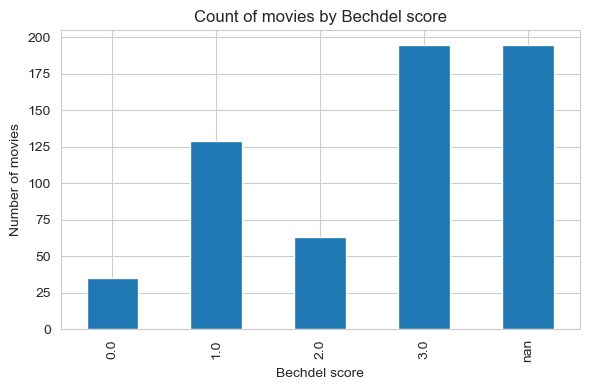

In [16]:
bechdel_counts = (
    df_meta['bechdel_score']
    .value_counts(dropna=False)
    .sort_index()
)

plt.figure(figsize=(6,4))
bechdel_counts.plot(kind='bar')
plt.xlabel('Bechdel score')
plt.ylabel('Number of movies')
plt.title('Count of movies by Bechdel score')
plt.tight_layout()
plt.show()


C:\Users\deeth\AppData\Local\Temp\ipykernel_32512\4098639034.py:11: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\deeth\miniconda3\envs\networkx_env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


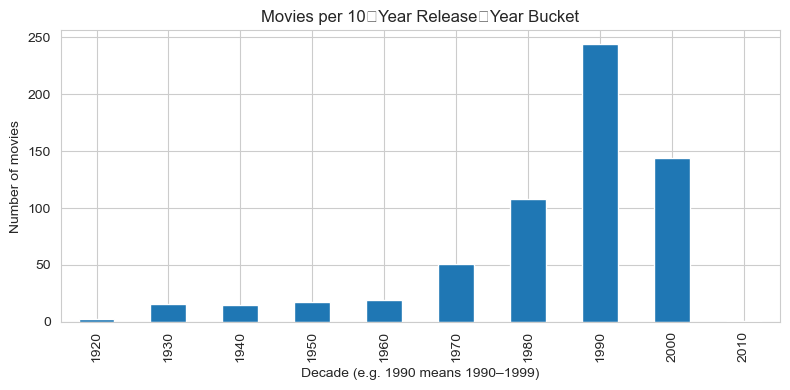

In [17]:
df_year = df_meta.dropna(subset=['release_year']).copy()

df_year['decade'] = (df_year['release_year'] // 10) * 10
decade_counts = df_year['decade'].value_counts().sort_index()

plt.figure(figsize=(8,4))
decade_counts.plot(kind='bar')
plt.xlabel('Decade (e.g. 1990 means 1990–1999)')
plt.ylabel('Number of movies')
plt.title('Movies per 10‐Year Release‐Year Bucket')
plt.tight_layout()
plt.show()

C:\Users\deeth\AppData\Local\Temp\ipykernel_32512\2764939085.py:40: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\deeth\miniconda3\envs\networkx_env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


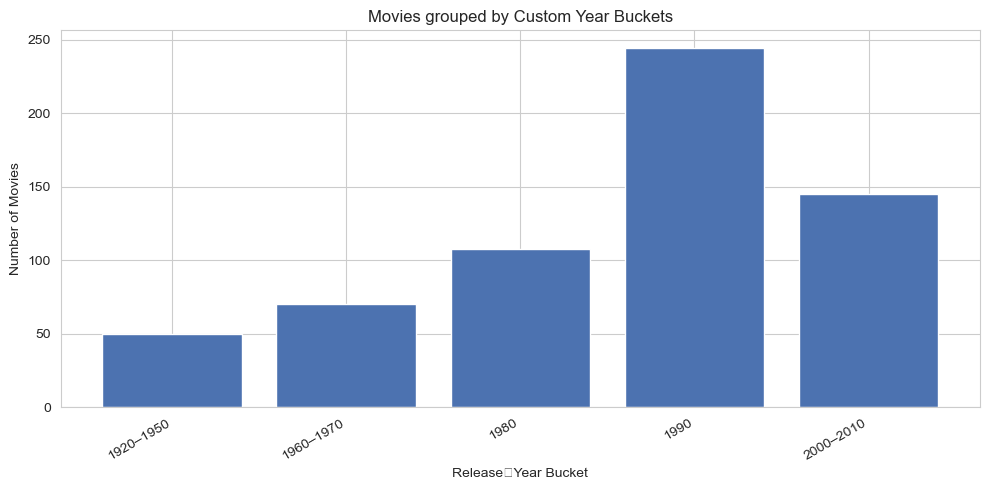

In [18]:
df_year = df_meta.dropna(subset=['release_year']).copy()

def to_custom_bucket(year):
    dec = (int(year) // 10) * 10
    if 1920 <= dec <= 1950:
        return '1920–1950'
    elif 1960 <= dec <= 1970:
        return '1960–1970'
    elif 2000 <= dec <= 2010:
        return '2000–2010'
    else:
        return str(dec)

df_year['bucket'] = df_year['release_year'].apply(to_custom_bucket)

bucket_counts = (
    df_year['bucket']
    .value_counts()
    .reset_index(name='count')
    .rename(columns={'index': 'bucket'})
)

def bucket_sort_key(bucket_label):
    if '–' in bucket_label:
        first_part = bucket_label.split('–')[0]
        return int(first_part)
    else:
        return int(bucket_label)

bucket_counts['sort_key'] = bucket_counts['bucket'].apply(bucket_sort_key)
bucket_counts = bucket_counts.sort_values('sort_key', ascending=True).reset_index(drop=True)
bucket_counts = bucket_counts.drop(columns=['sort_key'])

plt.figure(figsize=(10, 5))
plt.bar(bucket_counts['bucket'], bucket_counts['count'], color='#4C72B0')
plt.xlabel('Release‐Year Bucket')
plt.ylabel('Number of Movies')
plt.title('Movies grouped by Custom Year Buckets')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

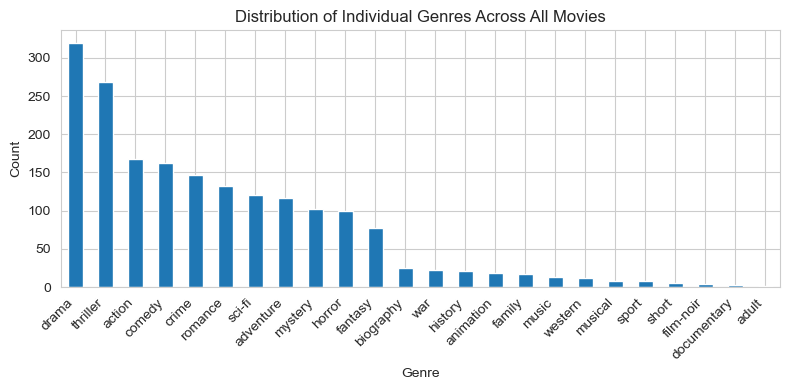

In [19]:
df_exploded = df_meta.explode('genre')
genre_counts = df_exploded['genre'].value_counts()

plt.figure(figsize=(8,4))
genre_counts.plot(kind='bar')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('Distribution of Individual Genres Across All Movies')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Graphs Construction and Visualization

In [20]:
df_users['gender'] =  df_users['gender'].astype(str).str.lower()

graphs_by_movie = {}

for mid, sub_df in df_grouped.groupby('movie_id'):
    G = nx.Graph()

    df_this_movie_users = df_users[df_users['movie_idx'] == mid]
    id_to_name   = df_this_movie_users.set_index('user_id')['character_name'].to_dict()
    id_to_gender = df_this_movie_users.set_index('user_id')['gender'].to_dict()

    unique_speakers = set(sub_df['speaker_1']).union(sub_df['speaker_2'])

    for uid in unique_speakers:
        char_name = id_to_name.get(uid, uid)
        gender    = id_to_gender.get(uid, '?')
        G.add_node(uid,
                   character_name=char_name,
                   gender=gender)

    for _, row in sub_df.iterrows():
        u = row['speaker_1']
        v = row['speaker_2']
        w = row['weight']
        if G.has_edge(u, v):
            G[u][v]['weight'] += w
        else:
            G.add_edge(u, v, weight=w)

    total_weight = sum(data['weight'] for _, _, data in G.edges(data=True))
    if total_weight > 0:
        for u, v, data in G.edges(data=True):
            data['weight'] = round(data['weight'] / total_weight, 2)

    if mid in meta_dict:
        G.graph['movie_name']   = meta_dict[mid]['movie_name']
        G.graph['release_year'] = meta_dict[mid]['release_year']
        G.graph['genre']        = meta_dict[mid]['genre']
        G.graph['bechdel_score']= meta_dict[mid]['bechdel_score']
    else:
        G.graph['movie_name']   = None
        G.graph['release_year'] = None
        G.graph['genre']        = None
        G.graph['bechdel_score']= None

    graphs_by_movie[mid] = G

In [21]:
def plot_movie_graph_with_node_attrs(movie_id,
                                     node_size=800,
                                     edge_width_factor=15):

    if movie_id not in graphs_by_movie:
        print(f"No graph found for movie_id {movie_id}")
        return

    G = graphs_by_movie[movie_id]
    movie_name = G.graph.get('movie_name', 'Unknown')

    node_colors = []
    labels = {}
    for uid, attrdict in G.nodes(data=True):
        gender = attrdict.get('gender', '?').lower()
        if gender == 'f':
            node_colors.append('#ff69b4')
        elif gender == 'm':
            node_colors.append('#1f77b4')
        else:
            node_colors.append('gray')
        labels[uid] = attrdict.get('character_name', uid)

    plt.figure(figsize=(6,6))
    pos = nx.spring_layout(G, seed=42)

    nx.draw_networkx_nodes(
        G, pos,
        node_size=node_size,
        node_color=node_colors
    )

    widths = []
    for u, v, data in G.edges(data=True):
        w = data.get('weight', 0)
        widths.append(w * edge_width_factor)

    nx.draw_networkx_edges(
        G, pos,
        width=widths,
        edge_color='gray',
        alpha=0.7
    )
    nx.draw_networkx_labels(
        G, pos,
        labels=labels,
        font_size=8
    )
    plt.title(f"Conversation Graph for \"{movie_name}\"", fontsize=10)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

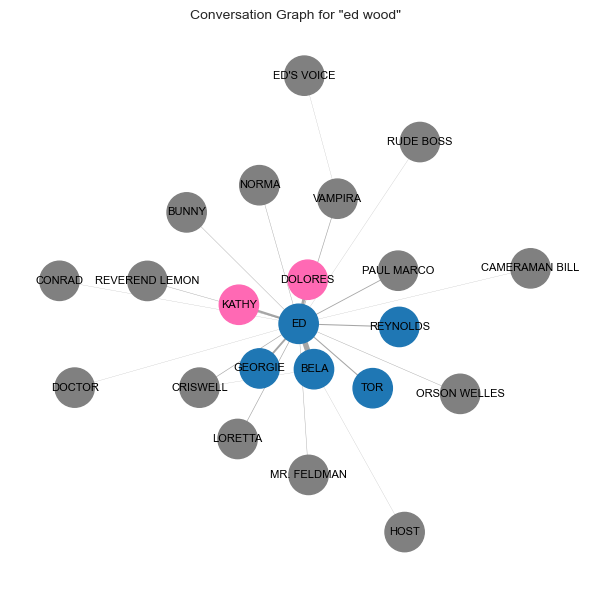

In [22]:
mid = df_conv["movie_idx"].sample(n=1).iloc[0]
plot_movie_graph_with_node_attrs(mid)

In [23]:
node_counts = []
edge_counts = []
known_gender_percents = []

for mid, G in graphs_by_movie.items():
    n_nodes = G.number_of_nodes()
    n_edges = G.number_of_edges()
    node_counts.append(n_nodes)
    edge_counts.append(n_edges)

    n_known = sum(
        1
        for _, attr in G.nodes(data=True)
        if attr.get('gender') not in (None, '?')
    )
    pct_known = (n_known / n_nodes) * 100 if n_nodes > 0 else 0
    known_gender_percents.append(pct_known)

node_counts = np.array(node_counts)
edge_counts = np.array(edge_counts)
known_gender_percents = np.array(known_gender_percents)


avg_nodes              = node_counts.mean()                if node_counts.size > 0              else 0
avg_edges              = edge_counts.mean()                if edge_counts.size > 0              else 0
avg_known_gender_pct   = known_gender_percents.mean()      if known_gender_percents.size > 0    else 0

median_nodes           = np.median(node_counts)            if node_counts.size > 0              else 0
median_edges           = np.median(edge_counts)            if edge_counts.size > 0              else 0
median_known_gender_pct = np.median(known_gender_percents) if known_gender_percents.size > 0    else 0

min_nodes, max_nodes        = (node_counts.min(), node_counts.max())             if node_counts.size > 0           else (0, 0)
min_edges, max_edges        = (edge_counts.min(), edge_counts.max())             if edge_counts.size > 0           else (0, 0)
min_known_pct, max_known_pct = (known_gender_percents.min(), known_gender_percents.max()) if known_gender_percents.size > 0 else (0, 0)


print(f"Computed over {len(graphs_by_movie)} movies:")
print(f"  • Average number of nodes per movie:                  {avg_nodes:.2f}")
print(f"  • Median number of nodes per movie:                   {median_nodes:.0f}")
print(f"  • Min/Max nodes per movie:                            {min_nodes} / {max_nodes}")
print()
print(f"  • Average number of edges per movie:                  {avg_edges:.2f}")
print(f"  • Median number of edges per movie:                   {median_edges:.0f}")
print(f"  • Min/Max edges per movie:                            {min_edges} / {max_edges}")
print()
print(f"  • Average % of nodes with known gender per movie:     {avg_known_gender_pct:.2f}%")
print(f"  • Median % of nodes with known gender per movie:      {median_known_gender_pct:.0f}%")
print(f"  • Min/Max % of nodes with known gender per movie:     {min_known_pct:.0f}% / {max_known_pct:.0f}%")


Computed over 617 movies:
  • Average number of nodes per movie:                  14.64
  • Median number of nodes per movie:                   14
  • Min/Max nodes per movie:                            2 / 44

  • Average number of edges per movie:                  17.26
  • Median number of edges per movie:                   17
  • Min/Max edges per movie:                            1 / 59

  • Average % of nodes with known gender per movie:     35.06%
  • Median % of nodes with known gender per movie:      33%
  • Min/Max % of nodes with known gender per movie:     0% / 86%


In [24]:
df_users_count = (
    df_users[['user_id', 'gender']]
    .drop_duplicates()
    .copy()
)
df_users_count['gender'] = df_users_count['gender'].str.lower()

count_series = df_users_count['gender'].value_counts()
df_counts = (
    count_series
    .rename_axis('gender')
    .reset_index(name='count')
)

total = df_counts['count'].sum()
df_counts['percent'] = (df_counts['count'] / total * 100).round(1)

print(f"Total entries: {total}")
for _, row in df_counts.iterrows():
    gender_code = row['gender']
    gender_label = {
        'f': 'Female',
        'm': 'Male',
        '?': 'Unknown'
    }.get(gender_code, gender_code)

    print(f"  • {gender_label:<7}: {row['count']:>4}  ({row['percent']:>5.1f}%)")


Total entries: 9035
  • Unknown: 6020  ( 66.6%)
  • Male   : 2049  ( 22.7%)
  • Female :  966  ( 10.7%)


In [25]:
df_known_pos = df_users[df_users['credit_pos'] != '?']

n_known_pos = len(df_known_pos)
n_known_gender = (df_known_pos['gender'] != '?').sum()

print(f"Users with known position (not '?'): {n_known_pos}")
print(f" ...of which, known gender (not '?'): {n_known_gender}")
print(f"Proportion with known gender: {n_known_gender/n_known_pos:.2%}" if n_known_pos > 0 else "No users with known position.")


Users with known position (not '?'): 2679
 ...of which, known gender (not '?'): 2679
Proportion with known gender: 100.00%


In [26]:
df_known_pos = df_users[df_users['gender'] != '?']

n_known_pos = len(df_known_pos)
n_known_gender = (df_known_pos['credit_pos'] != '?').sum()

print(f"Users with known gender (not '?'): {n_known_pos}")
print(f" ...of which, known position (not '?'): {n_known_gender}")
print(f"Proportion with known position: {n_known_gender/n_known_pos:.2%}" if n_known_pos > 0 else "No users with known position.")

Users with known gender (not '?'): 3015
 ...of which, known position (not '?'): 2679
Proportion with known position: 88.86%


### Metrics Calculation

In [27]:
def get_max_gender(metric, genders):
    valid_nodes = [n for n in metric if genders.get(n, '?') in {'m', 'f'}]
    if not valid_nodes:
        return None

    sorted_nodes = sorted(valid_nodes, key=lambda k: metric[k], reverse=True)
    top_value = metric[sorted_nodes[0]]
    top_nodes = [n for n in sorted_nodes if metric[n] == top_value]
    top_genders = [genders.get(n, '?') for n in top_nodes]

    if len(set(top_genders)) == 1:
        return top_genders[0]

    if len(top_genders) > 2:
        counts = {'m': top_genders.count('m'), 'f': top_genders.count('f')}
        if counts['m'] > counts['f']:
            return 'm'
        elif counts['f'] > counts['m']:
            return 'f'
        else:
            if len(sorted_nodes) > 2:
                next_best_value = metric[sorted_nodes[2]]
                next_best_nodes = [n for n in sorted_nodes if metric[n] == next_best_value]
                next_best_genders = [genders.get(n, '?') for n in next_best_nodes if genders.get(n, '?') in {'m', 'f'}]
                return next_best_genders[0] if next_best_genders else '?'
            else:
                return '?'

    elif len(top_genders) == 2:
        if len(sorted_nodes) > 2:
            next_best_value = metric[sorted_nodes[2]]
            next_best_nodes = [n for n in sorted_nodes if metric[n] == next_best_value]
            next_best_genders = [genders.get(n, '?') for n in next_best_nodes if genders.get(n, '?') in {'m', 'f'}]
            return next_best_genders[0] if next_best_genders else '?'
        else:
            return '?'



def calc_graph_metrics(graphs_by_movie, df_meta):
    meta_idx = df_meta.set_index('movie_id')

    records = []

    for movie_id, G in graphs_by_movie.items():
        meta = meta_idx.loc[movie_id] if movie_id in meta_idx.index else {}
        genres = meta['genre'] if 'genre' in meta else []
        release_year = meta['release_year'] if 'release_year' in meta else None
        bechdel_score = meta['bechdel_score'] if 'bechdel_score' in meta else None
        movie_name = meta['movie_name'] if 'movie_name' in meta else None

        genders = nx.get_node_attributes(G, 'gender')
        all_nodes = list(G.nodes())
        female_nodes = [n for n in all_nodes if genders.get(n, '?') == 'f']
        male_nodes   = [n for n in all_nodes if genders.get(n, '?') == 'm']

        degree = dict(G.degree(weight='weight'))
        unweighted_degree = dict(G.degree())
        betweenness = nx.betweenness_centrality(G, weight='weight')
        closeness = nx.closeness_centrality(G, distance='weight')
        clustering = nx.clustering(G, weight='weight')
        try:
            pagerank = nx.pagerank(G, weight='weight')
        except Exception:
            pagerank = {n: np.nan for n in G.nodes()}

        def avg(metric, group): return np.mean([metric[n] for n in group]) if group else np.nan
        def std(metric, group): return np.std([metric[n] for n in group]) if group else np.nan


        deg_vals = np.array(list(degree.values()))
        centralization = (
                np.sum(deg_vals.max() - deg_vals) / ((len(deg_vals)-1)*(len(deg_vals)-2))
                if len(deg_vals) > 2 else np.nan
            )

        density = nx.density(G)
        try:
            diameter = nx.diameter(G)
        except nx.NetworkXError:
            diameter = np.nan
        try:
            avg_shortest = nx.average_shortest_path_length(G, weight='weight')
        except nx.NetworkXError:
            avg_shortest = np.nan

        n_nodes = len(all_nodes)
        n_edges = len(G.edges())
        n_female = len(female_nodes)
        n_male   = len(male_nodes)
        pct_known_gender = 100 * len([n for n in all_nodes if genders.get(n, '?') in {'m','f'}]) / n_nodes if n_nodes else np.nan

        row = {
            'movie_id': movie_id,
            'movie_name': movie_name,
            'release_year': release_year,
            'genres': genres,
            'bechdel_score': bechdel_score,

            'n_nodes': n_nodes,
            'n_edges': n_edges,
            'n_female': n_female,
            'n_male': n_male,
            'pct_known_gender': pct_known_gender,

            'density': density,
            'diameter': diameter,
            'avg_shortest_path': avg_shortest,
            'centralization': centralization,

            'degree_all_mean': avg(degree, all_nodes),
            'degree_f_mean': avg(degree, female_nodes),
            'degree_m_mean': avg(degree, male_nodes),

            'unweighted_degree_all_mean': avg(unweighted_degree, all_nodes),
            'unweighted_degree_f_mean': avg(unweighted_degree, female_nodes),
            'unweighted_degree_m_mean': avg(unweighted_degree, male_nodes),

            'betweenness_all_mean': avg(betweenness, all_nodes),
            'betweenness_f_mean': avg(betweenness, female_nodes),
            'betweenness_m_mean': avg(betweenness, male_nodes),

            'closeness_all_mean': avg(closeness, all_nodes),
            'closeness_f_mean': avg(closeness, female_nodes),
            'closeness_m_mean': avg(closeness, male_nodes),

            'clustering_all_mean': avg(clustering, all_nodes),
            'clustering_f_mean': avg(clustering, female_nodes),
            'clustering_m_mean': avg(clustering, male_nodes),

            'pagerank_all_mean': avg(pagerank, all_nodes),
            'pagerank_f_mean': avg(pagerank, female_nodes),
            'pagerank_m_mean': avg(pagerank, male_nodes),

            'top_degree_gender': get_max_gender(degree, genders),
            'top_unw_degree_gender': get_max_gender(unweighted_degree, genders),
            'top_betweenness_gender': get_max_gender(betweenness, genders),
            'top_pagerank_gender': get_max_gender(pagerank, genders),
            'top_closeness_gender': get_max_gender(closeness, genders),
            'top_clustering_gender': get_max_gender(clustering, genders),
        }

        records.append(row)

    return pd.DataFrame(records)


In [28]:
df_metrics = calc_graph_metrics(graphs_by_movie, df_meta)
df_metrics

movie_id                            movie_name  release_year  \
0         m0            10 things i hate about you          1999   
1         m1            1492: conquest of paradise          1992   
2        m10                            affliction          1997   
3       m100                            innerspace          1987   
4       m101                           the insider          1999   
..       ...                                   ...           ...   
612      m95                           i am legend          2007   
613      m96                    invaders from mars          1953   
614      m97                      independence day          1996   
615      m98    indiana jones and the last crusade          1989   
616      m99  indiana jones and the temple of doom          1984   

                                                genres  bechdel_score  \
0                                    [comedy, romance]            3.0   
1               [adventure, biography, drama, history]            NaN   
2                           [drama, mystery, thriller]            NaN   
3           [action, adventure, comedy, crime, sci-fi]            NaN   
4                         [biography, drama, thriller]            NaN   
..                                                 ...            ...   
612                          [drama, sci-fi, thriller]            3.0   
613                                   [horror, sci-fi]            NaN   
614              [action, adventure, sci-fi, thriller]            3.0   
615  [action, adventure, thriller, action, adventur...            0.0   
616                                [action, adventure]            0.0   

     n_nodes  n_edges  n_female  n_male  pct_known_gender  ...  \
0         12       19         3       5         66.666667  ...   
1         14       14         0       2         14.285714  ...   
2         16       17         3       5         50.000000  ...   
3         16       22         1       2         18.750000  ...   
4         27       31         2       4         22.222222  ...   
..       ...      ...       ...     ...               ...  ...   
612        5        4         1       1         40.000000  ...   
613        6        7         1       2         50.000000  ...   
614       19       18         2       5         36.842105  ...   
615        9       11         1       4         55.555556  ...   
616        8       11         1       1         25.000000  ...   

     clustering_m_mean  pagerank_all_mean  pagerank_f_mean  pagerank_m_mean  \
0             0.055680           0.083333         0.133148         0.102311   
1             0.005482           0.071429              NaN         0.224131   
2             0.112835           0.062500         0.053694         0.131786   
3             0.048455           0.062500         0.105908         0.265719   
4             0.049701           0.037037         0.031424         0.148576   
..                 ...                ...              ...              ...   
612           0.000000           0.200000         0.292810         0.475677   
613           0.326297           0.166667         0.261946         0.255579   
614           0.044450           0.052632         0.055646         0.082550   
615           0.113048           0.111111         0.079921         0.196989   
616           0.032864           0.125000         0.269915         0.416649   

     top_degree_gender  top_unw_degree_gender  top_betweenness_gender  \
0                    f                      f                       f   
1                    m                      m                       m   
2                    m                      m                       m   
3                    m                      m                       m   
4                    m                      m                       m   
..                 ...                    ...                     ...   
612                  m                      m            

### By Year Annalysis

In [29]:
def to_year_bracket(year):
    try:
        year = int(year)
    except (ValueError, TypeError):
        return 'Unknown'
    if 1920 <= year <= 1959:
        return '1920–1950s'
    elif 1960 <= year <= 1979:
        return '1960–1970s'
    elif 1980 <= year <= 1989:
        return '1980s'
    elif 1990 <= year <= 1999:
        return '1990s'
    elif year >= 2000:
        return '2000+'
    else:
        return 'Unknown'

df_metrics['year_bracket'] = df_metrics['release_year'].apply(to_year_bracket)


In [30]:
def male_female_year_comp(metric):
    grouped = (
        df_metrics
        .groupby('year_bracket')
        .agg({
            f'{metric}_f_mean': ['mean', 'std', 'count'],
            f'{metric}_m_mean': ['mean', 'std', 'count'],
        })
    )

    grouped.columns = ['_'.join(col) for col in grouped.columns]
    grouped = grouped.reset_index()


    plt.figure(figsize=(10,5))
    df_long = df_metrics.melt(id_vars=['year_bracket'],
                             value_vars=[f'{metric}_f_mean',f'{metric}_m_mean'],
                             var_name='gender', value_name=f'mean_{metric}')
    df_long['gender'] = df_long['gender'].map({f'{metric}_f_mean':'Female',f'{metric}_m_mean':'Male'})

    year_order = ['1920–1950s', '1960–1970s', '1980s', '1990s', '2000+']

    sns.boxplot(
        x='year_bracket',
        y=f'mean_{metric}',
        hue='gender',
        data=df_long,
        palette=['hotpink','royalblue'],
        order=year_order
    )
    plt.xlabel('Year Bracket')
    plt.ylabel(f'Mean {metric} Centrality (per movie)')
    plt.title(f'Distribution of Mean {metric} by Gender and Year')
    plt.tight_layout()
    plt.show()


    diff = grouped[f'{metric}_m_mean_mean'] - grouped[f'{metric}_f_mean_mean']
    err = np.sqrt(grouped[f'{metric}_m_mean_std']**2 + grouped[f'{metric}_f_mean_std']**2)

    plt.figure(figsize=(8,4))
    plt.errorbar(grouped['year_bracket'], diff, yerr=err, fmt='o-', color='black', capsize=5)
    plt.axhline(0, color='gray', linestyle='--')
    plt.xlabel('Year Bracket')
    plt.ylabel(f'Difference in Mean {metric} (M-F)')
    plt.title(f'Gender Gap in {metric} Over Time')
    plt.tight_layout()
    plt.show()


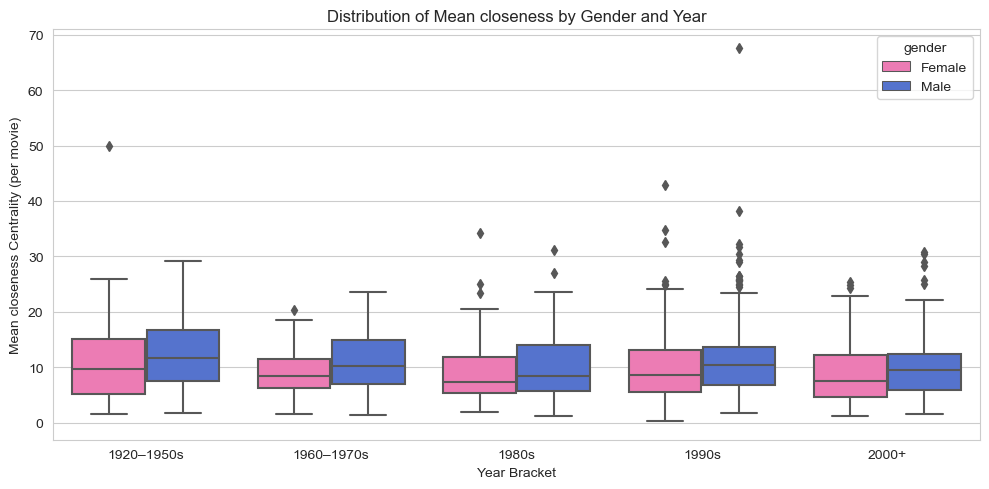

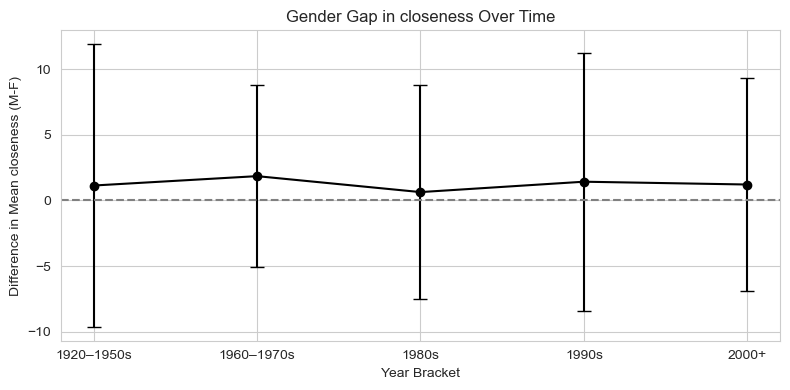

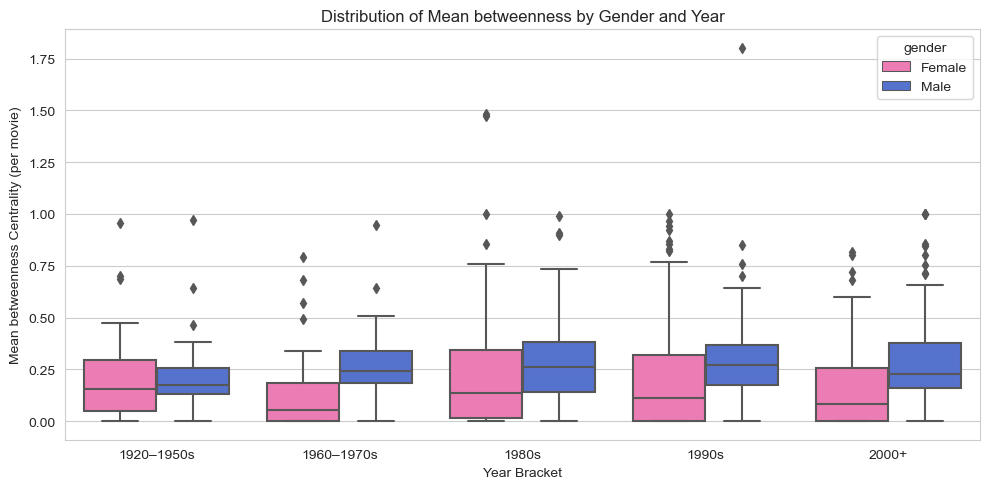

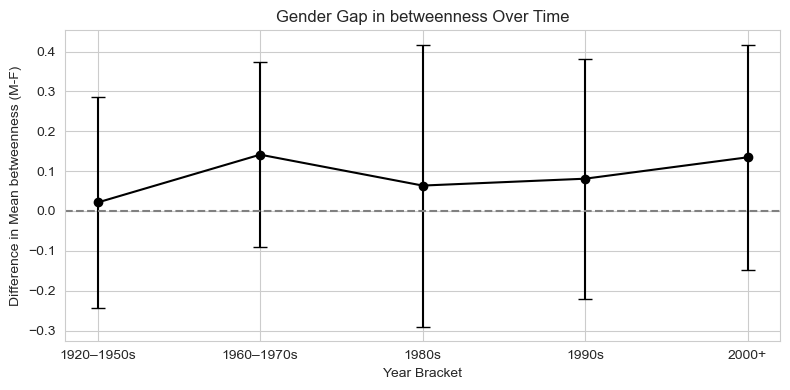

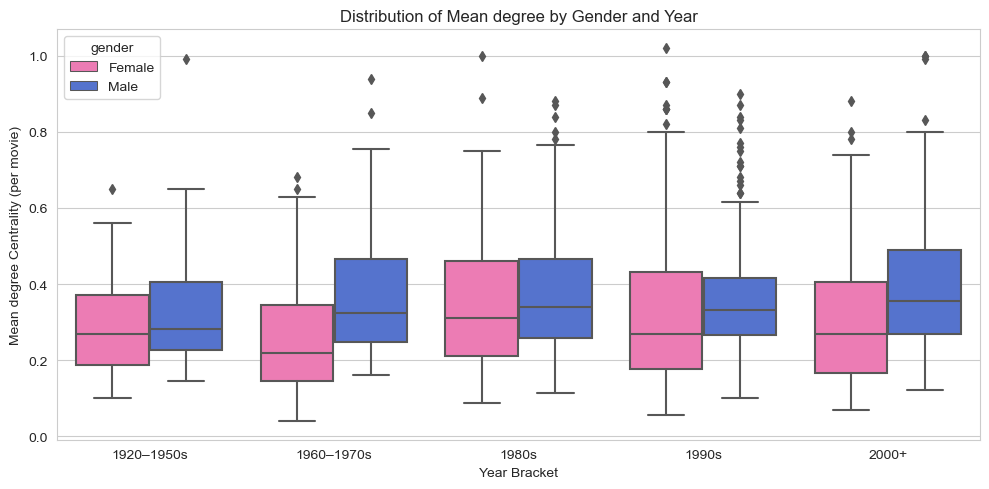

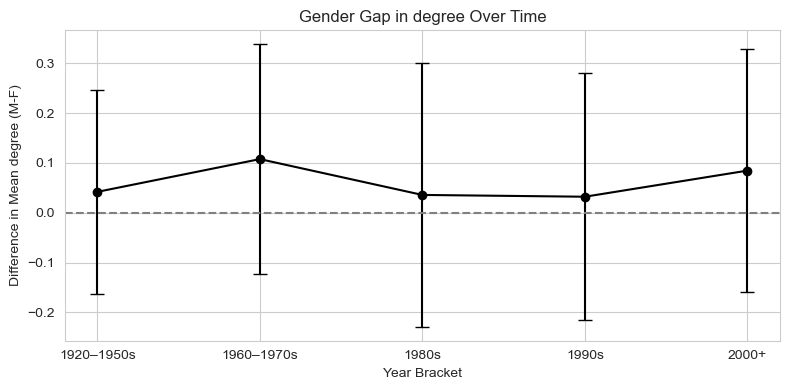

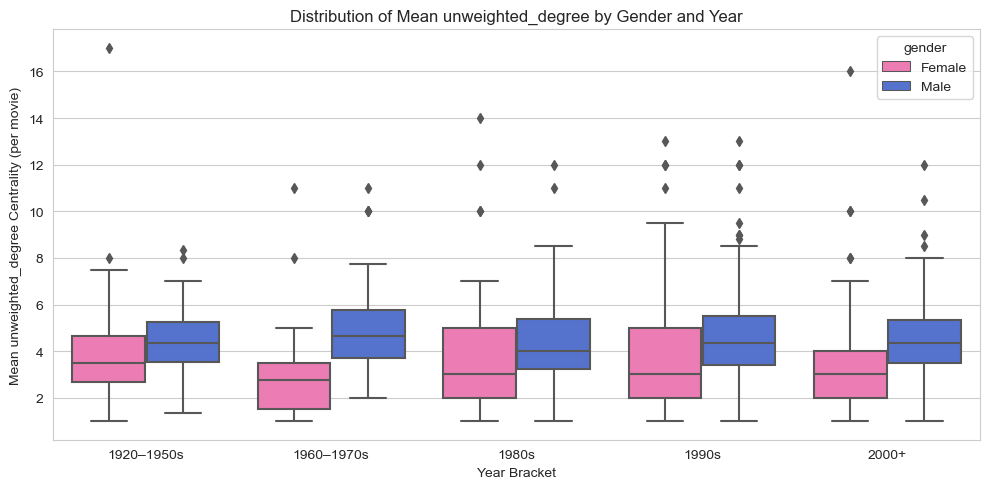

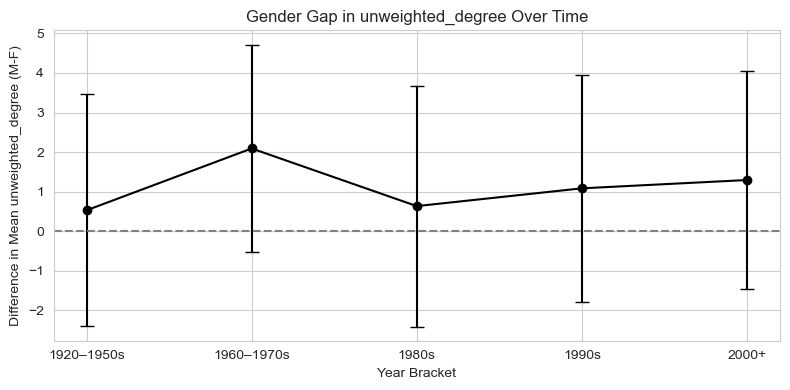

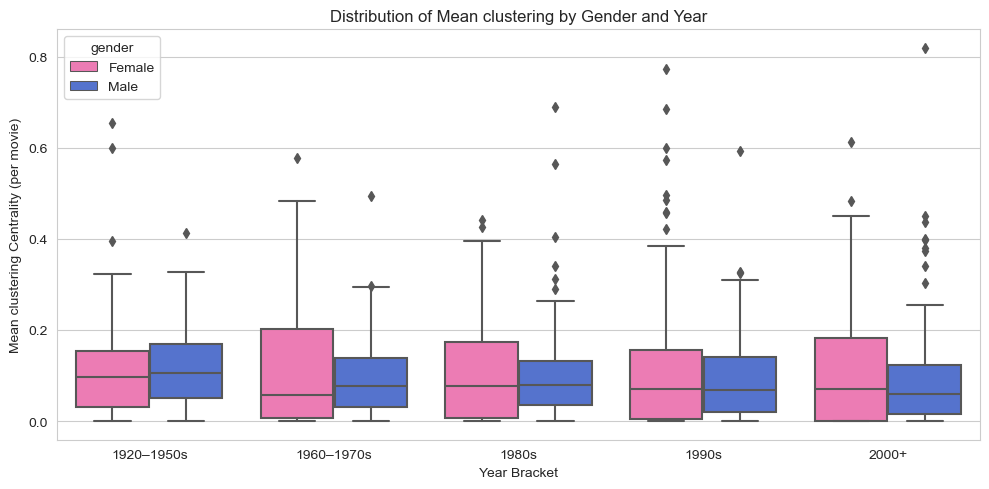

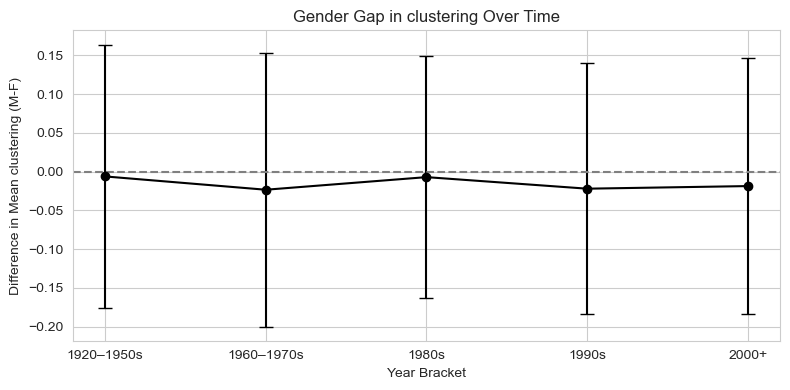

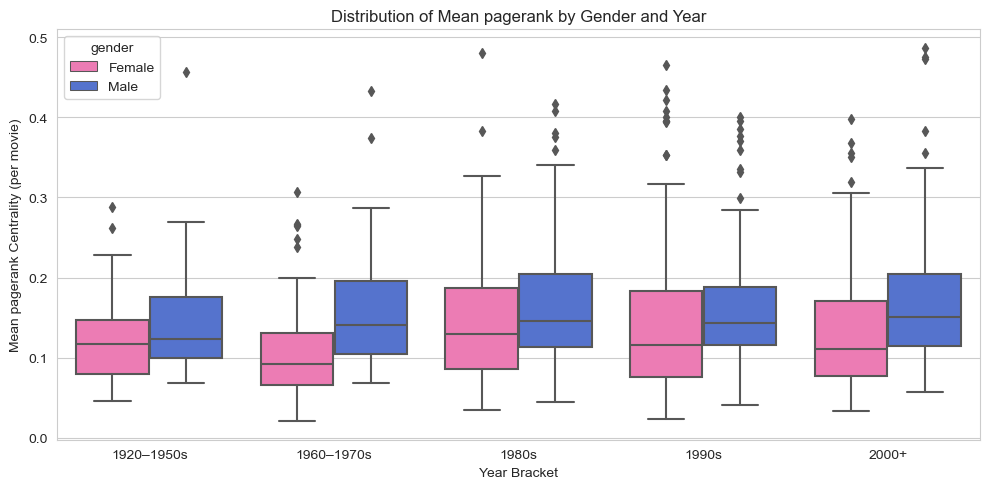

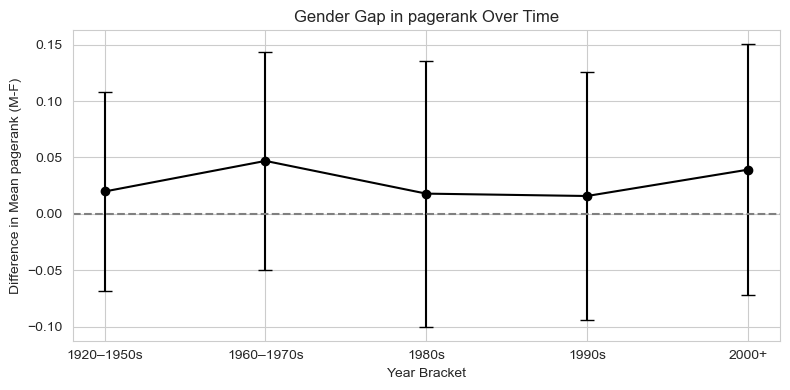

In [31]:
metrics = ['closeness', 'betweenness', 'degree', 'unweighted_degree', 'clustering', 'pagerank']

for met in metrics:
    male_female_year_comp(met)

In [32]:
from scipy.stats import ttest_ind

metrics = ['closeness', 'betweenness', 'degree', 'unweighted_degree', 'clustering', 'pagerank']
year_order = ['1920–1950s', '1960–1970s', '1980s', '1990s', '2000+']

pvals = {metric: {} for metric in metrics}

for metric in metrics:
    for year in year_order:
        f_vals = df_metrics.loc[df_metrics['year_bracket'] == year, f'{metric}_f_mean'].dropna()
        m_vals = df_metrics.loc[df_metrics['year_bracket'] == year, f'{metric}_m_mean'].dropna()
        if len(f_vals) > 1 and len(m_vals) > 1:
            t, p = ttest_ind(m_vals, f_vals, equal_var=False, nan_policy='omit')
            pvals[metric][year] = p
        else:
            pvals[metric][year] = None

summary_df = pd.DataFrame(pvals).T[year_order]

def signif_marker(p):
    if p is None:
        return "N/A"
    elif p < 0.05:
        return "✓"
    else:
        return "✗"

summary_display = summary_df.map(signif_marker)
print("Significance summary (✓ = p < 0.05, ✗ = not significant, N/A = insufficient data):")
display(summary_display)


Significance summary (✓ = p < 0.05, ✗ = not significant, N/A = insufficient data):


1920–1950s 1960–1970s 1980s 1990s 2000+
closeness                  ✗          ✓     ✗     ✓     ✗
betweenness                ✗          ✓     ✗     ✓     ✓
degree                     ✗          ✓     ✗     ✗     ✓
unweighted_degree          ✗          ✓     ✓     ✓     ✓
clustering                 ✗          ✗     ✗     ✓     ✗
pagerank                   ✗          ✓     ✗     ✓     ✓

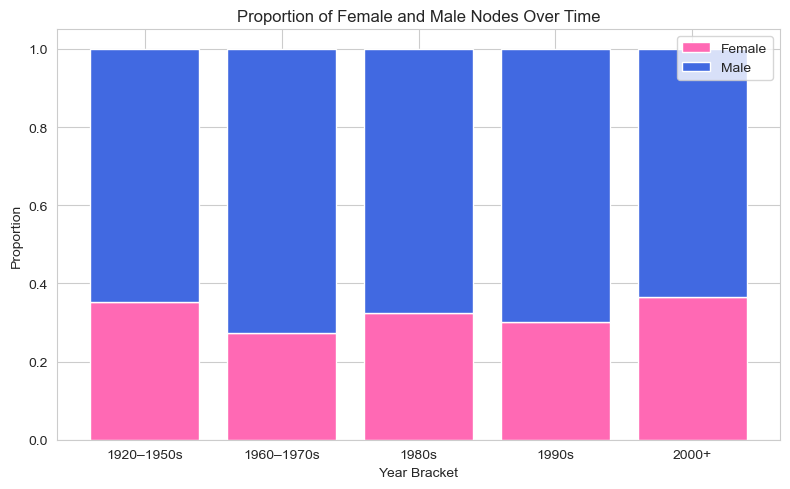

In [33]:
by_year = df_metrics.groupby('year_bracket').agg({
    'n_female': 'sum',
    'n_male': 'sum',
    'pct_known_gender': 'mean'
}).reset_index()

by_year['total'] = by_year['n_female'] + by_year['n_male']
by_year['prop_female'] = by_year['n_female'] / by_year['total']
by_year['prop_male'] = by_year['n_male'] / by_year['total']

plt.figure(figsize=(8,5))
plt.bar(by_year['year_bracket'], by_year['prop_female'], label='Female', color='hotpink')
plt.bar(by_year['year_bracket'], by_year['prop_male'], bottom=by_year['prop_female'], label='Male', color='royalblue')
plt.xlabel('Year Bracket')
plt.ylabel('Proportion')
plt.title('Proportion of Female and Male Nodes Over Time')
plt.legend()
plt.tight_layout()
plt.show()


In [34]:
centrality_cols = [
    'top_degree_gender',
    'top_unw_degree_gender',
    'top_betweenness_gender',
    'top_pagerank_gender',
    'top_closeness_gender',
    'top_clustering_gender'
]

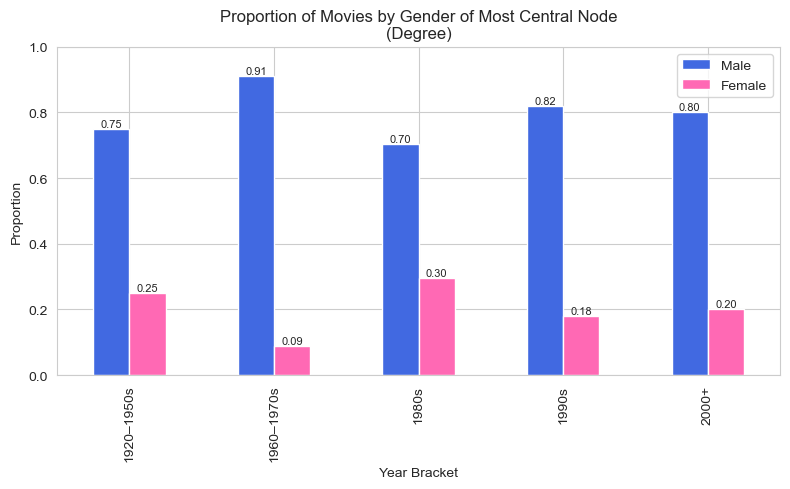

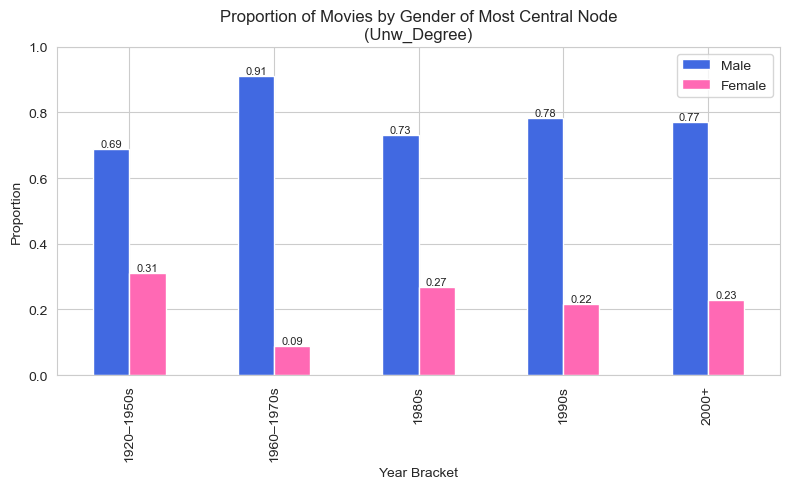

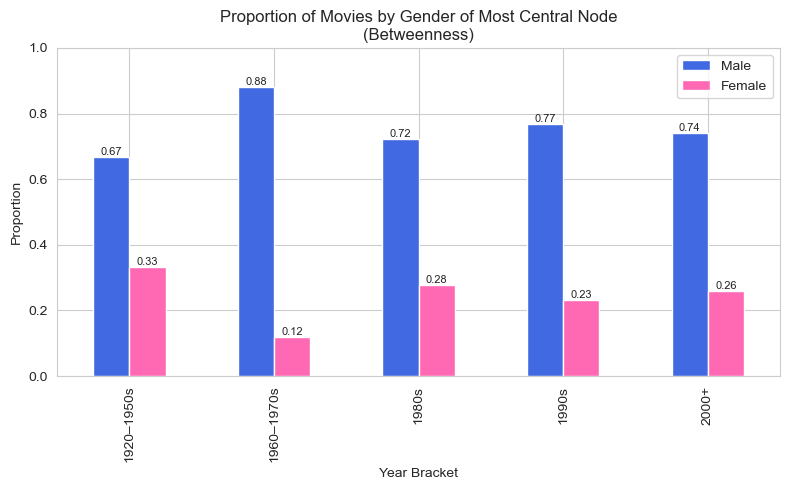

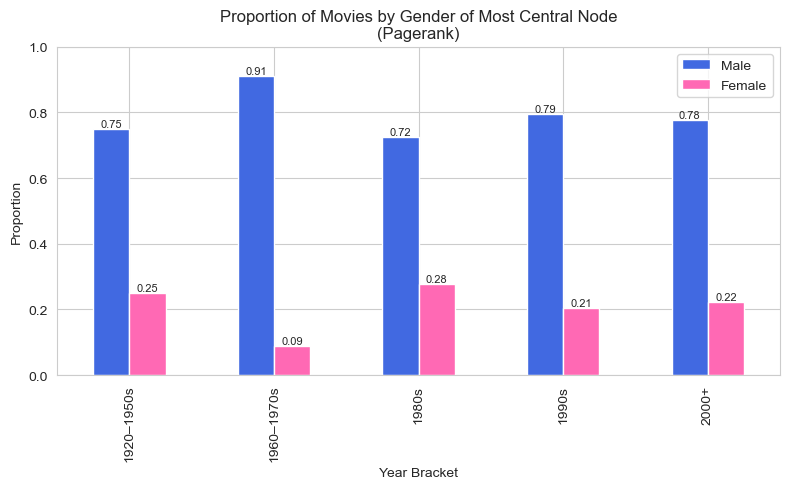

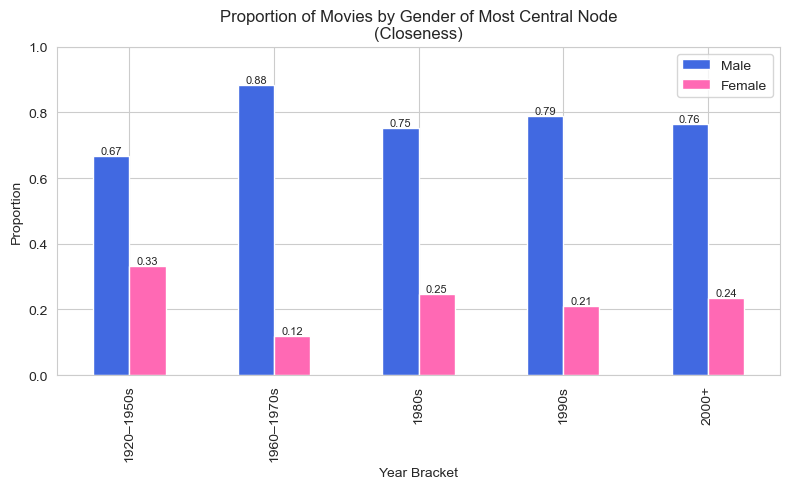

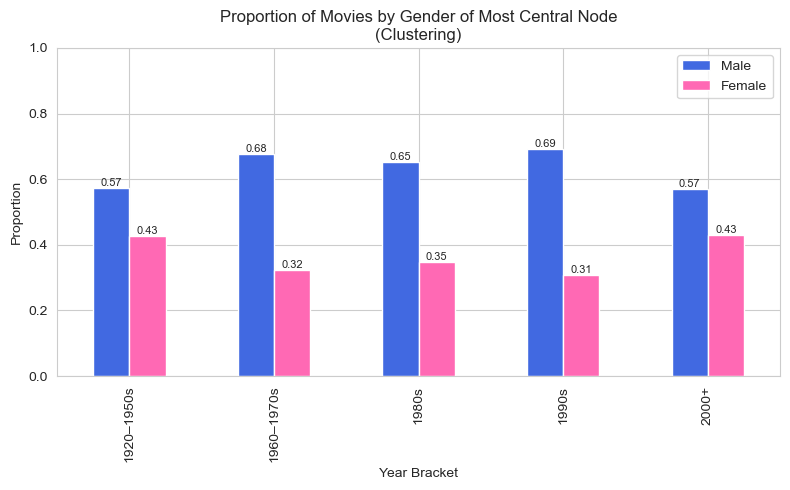

In [35]:
import numpy as np

for col in centrality_cols:
    gender_counts = (
        df_metrics.groupby(['year_bracket', col])
        .size()
        .unstack(fill_value=0)[['m', 'f']]
    )
    prop = gender_counts.div(gender_counts.sum(axis=1), axis=0)
    ax = prop.plot(kind='bar', figsize=(8,5), color=['royalblue','hotpink'])
    plt.title(f"Proportion of Movies by Gender of Most Central Node\n({col.replace('top_','').replace('_gender','').title()})")
    plt.xlabel('Year Bracket')
    plt.ylabel('Proportion')
    plt.ylim(0,1)
    plt.legend(['Male','Female'], loc='upper right')
    for p in ax.patches:
        height = p.get_height()
        if not np.isnan(height):
            ax.annotate(f"{height:.2f}", (p.get_x() + p.get_width() / 2, height),
                        ha='center', va='bottom', fontsize=8)
    plt.tight_layout()
    plt.show()


In [36]:
df_metrics['bechdel_score'] = pd.to_numeric(df_metrics['bechdel_score'], errors='coerce')
df_bech = df_metrics[df_metrics['bechdel_score'].isin([0, 1, 2, 3])].copy()


In [37]:
# Group by year_bracket and bechdel_score
count_table = (
    df_bech.groupby(['year_bracket', 'bechdel_score'])
    .size()
    .unstack(fill_value=0)
    .reindex(columns=[0,1,2,3])  # ensure correct order
    .reindex(['1920–1950s', '1960–1970s', '1980s', '1990s', '2000+'])  # order years
)

# Calculate proportions
prop_table = count_table.div(count_table.sum(axis=1), axis=0)


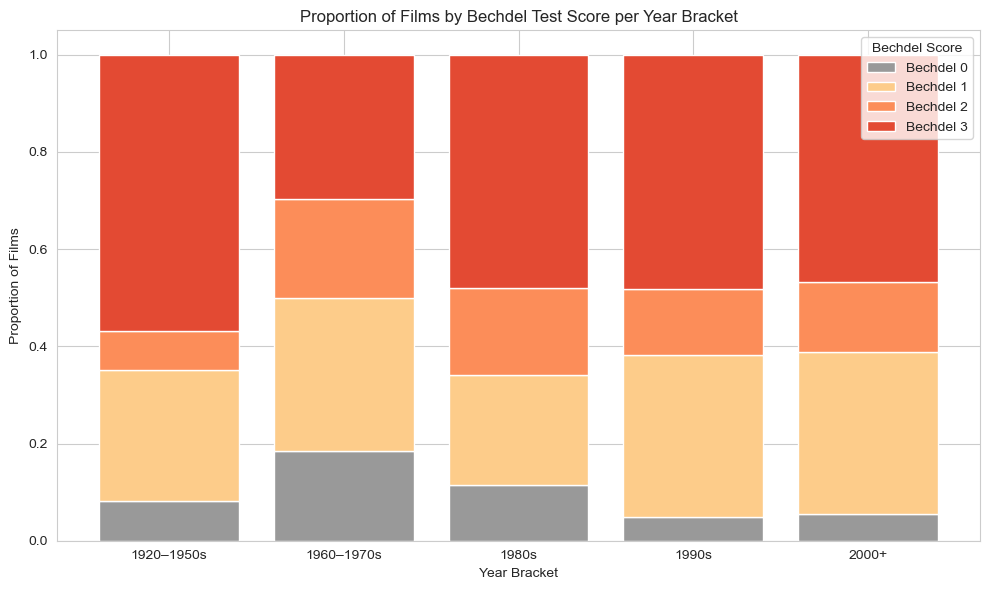

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
bottom = np.zeros(len(prop_table))
colors = ['#999999', '#fdcc8a', '#fc8d59', '#e34a33']  # adjust as desired

for i, score in enumerate([0, 1, 2, 3]):
    plt.bar(
        prop_table.index,
        prop_table[score],
        bottom=bottom,
        label=f'Bechdel {score}',
        color=colors[i]
    )
    bottom += prop_table[score].values

plt.xlabel('Year Bracket')
plt.ylabel('Proportion of Films')
plt.title('Proportion of Films by Bechdel Test Score per Year Bracket')
plt.legend(title='Bechdel Score')
plt.tight_layout()
plt.show()


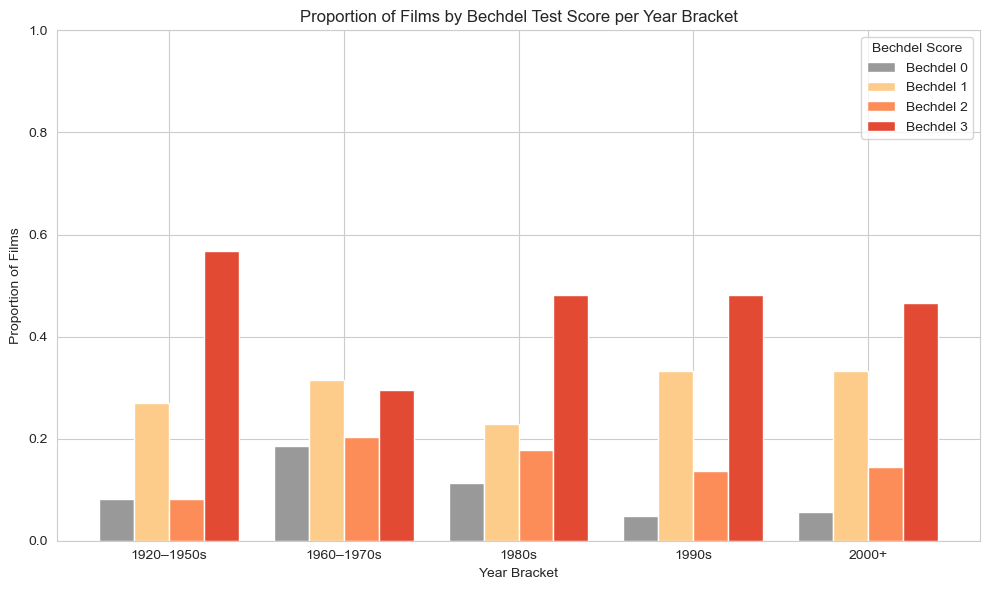

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data as above
df_metrics['bechdel_score'] = pd.to_numeric(df_metrics['bechdel_score'], errors='coerce')
df_bech = df_metrics[df_metrics['bechdel_score'].isin([0, 1, 2, 3])].copy()

year_order = ['1920–1950s', '1960–1970s', '1980s', '1990s', '2000+']
score_order = [0, 1, 2, 3]

count_table = (
    df_bech.groupby(['year_bracket', 'bechdel_score'])
    .size()
    .unstack(fill_value=0)
    .reindex(columns=score_order)
    .reindex(year_order)
)
prop_table = count_table.div(count_table.sum(axis=1), axis=0)

# Plot grouped barplot
plt.figure(figsize=(10,6))
bar_width = 0.2
x = np.arange(len(year_order))

colors = ['#999999', '#fdcc8a', '#fc8d59', '#e34a33']

for i, score in enumerate(score_order):
    plt.bar(
        x + (i - 1.5)*bar_width,    # centers bars on ticks
        prop_table[score],
        width=bar_width,
        label=f'Bechdel {score}',
        color=colors[i]
    )

plt.xlabel('Year Bracket')
plt.ylabel('Proportion of Films')
plt.title('Proportion of Films by Bechdel Test Score per Year Bracket')
plt.xticks(x, year_order)
plt.ylim(0,1)
plt.legend(title='Bechdel Score')
plt.tight_layout()
plt.show()


### Genre Analysis

In [40]:
main_genres = [
    'drama', 'thriller', 'action', 'comedy', 'crime', 'romance',
    'sci-fi', 'adventure', 'mystery', 'horror', 'fantasy'
]


In [41]:
genre_col = 'genres' if 'genres' in df_metrics.columns else 'genre'

df_metrics[genre_col] = df_metrics[genre_col].apply(lambda x: x if isinstance(x, list) else eval(x))

df_exploded = df_metrics.explode(genre_col)
df_exploded = df_exploded.rename(columns={genre_col: 'genre'})

df_main_genres = df_exploded[df_exploded['genre'].isin(main_genres)].copy()

In [42]:
def male_female_genre_comp(df, metric, genre_order):
    grouped = (
        df
        .groupby('genre')
        .agg({
            f'{metric}_f_mean': ['mean', 'std', 'count'],
            f'{metric}_m_mean': ['mean', 'std', 'count'],
        })
    )

    grouped.columns = ['_'.join(col) for col in grouped.columns]
    grouped = grouped.reset_index()

    grouped = grouped.set_index('genre').reindex(genre_order).reset_index()

    plt.figure(figsize=(10,5))
    df_long = df.melt(id_vars=['genre'],
                             value_vars=[f'{metric}_f_mean',f'{metric}_m_mean'],
                             var_name='gender', value_name=f'mean_{metric}')
    df_long['gender'] = df_long['gender'].map({f'{metric}_f_mean':'Female',f'{metric}_m_mean':'Male'})

    sns.boxplot(
        x='genre',
        y=f'mean_{metric}',
        hue='gender',
        data=df_long,
        palette=['hotpink','royalblue'],
        order=genre_order
    )
    plt.xlabel('Genre')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel(f'Mean {metric} Centrality (per movie)')
    plt.title(f'Distribution of Mean {metric} by Gender and Year')
    plt.tight_layout()
    plt.show()


    diff = grouped[f'{metric}_m_mean_mean'] - grouped[f'{metric}_f_mean_mean']
    err = np.sqrt(grouped[f'{metric}_m_mean_std']**2 + grouped[f'{metric}_f_mean_std']**2)

    plt.figure(figsize=(8,4))
    plt.errorbar(grouped['genre'], diff, yerr=err, fmt='o-', color='black', capsize=5)
    plt.axhline(0, color='gray', linestyle='--')
    plt.xlabel('Genre')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel(f'Difference in Mean {metric} (M-F)')
    plt.title(f'Gender Gap in {metric} Over Time')
    plt.tight_layout()
    plt.show()

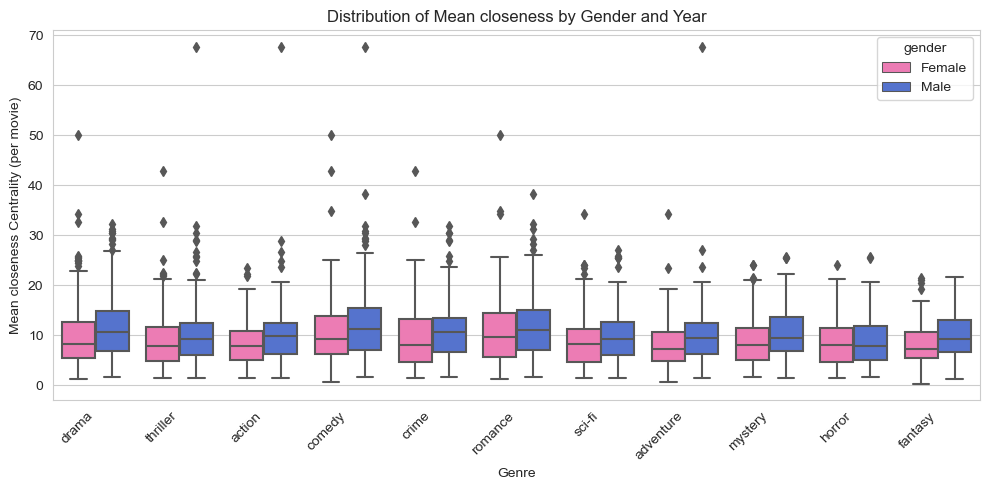

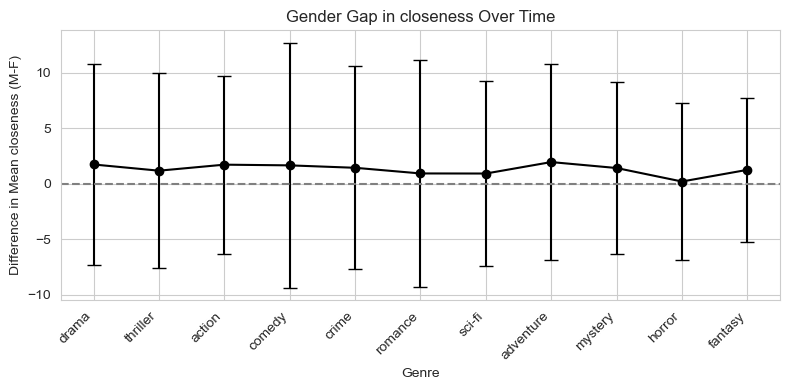

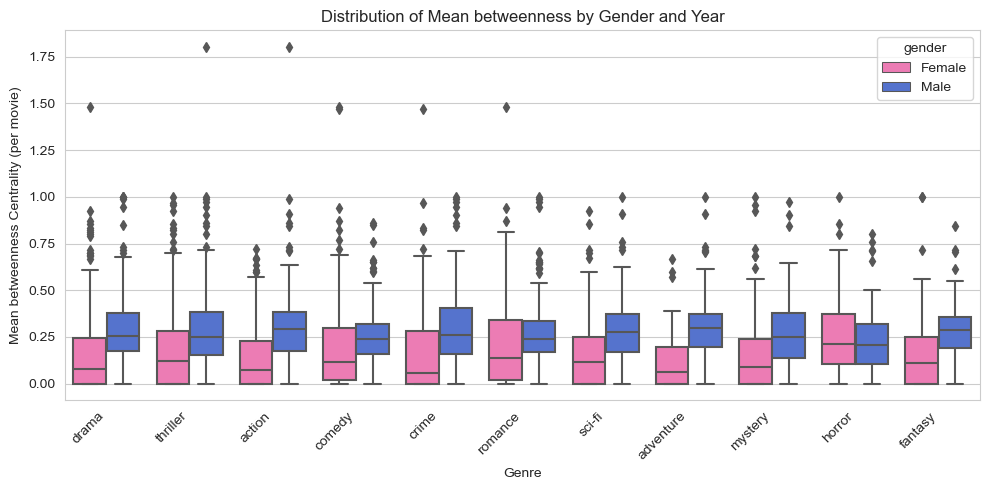

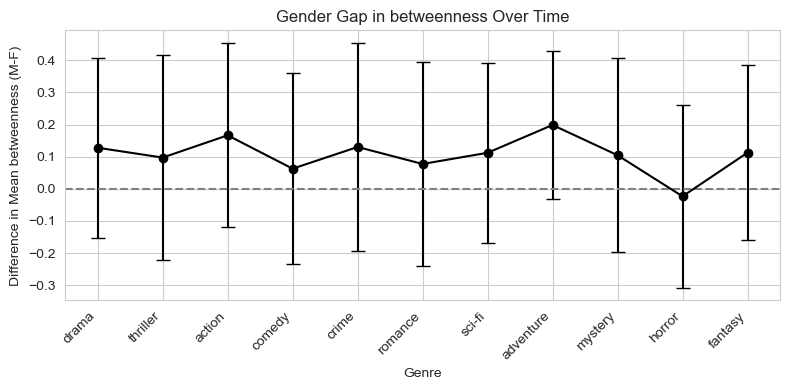

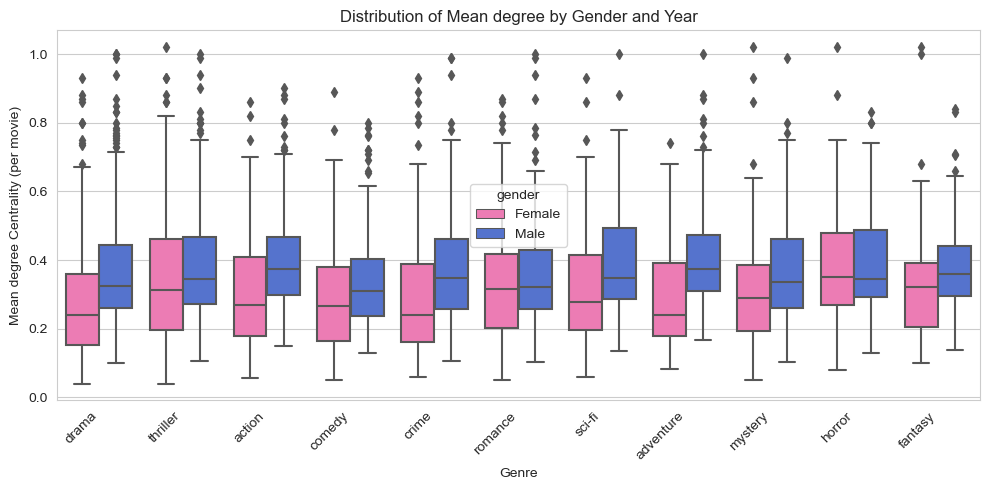

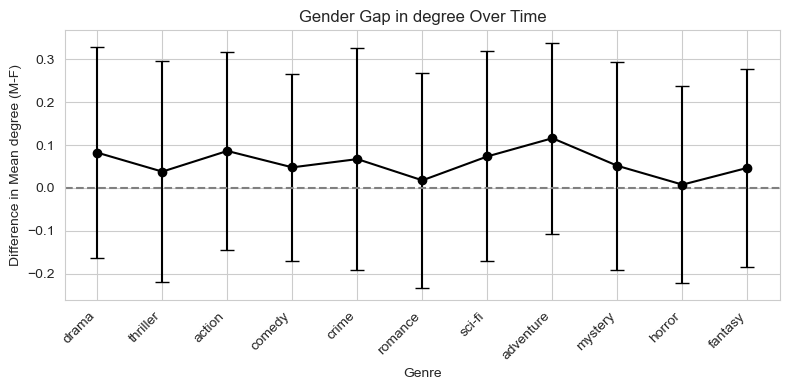

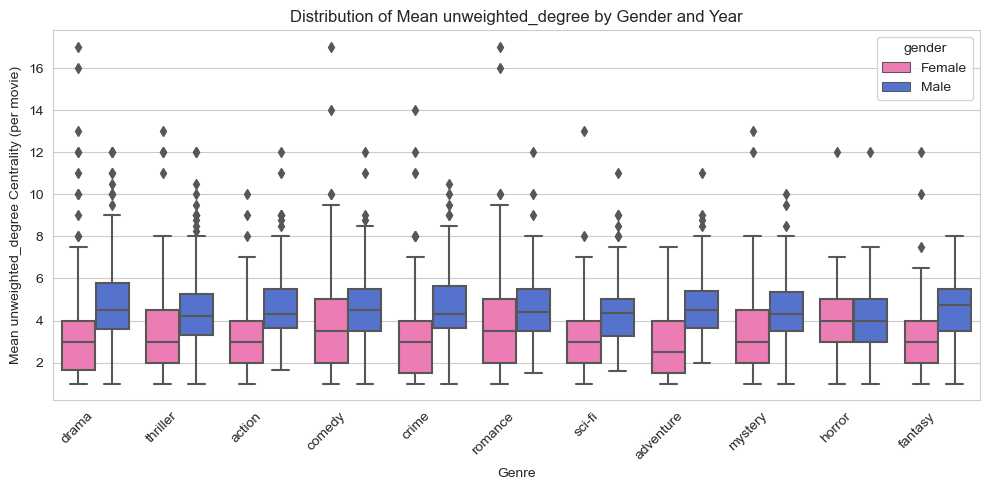

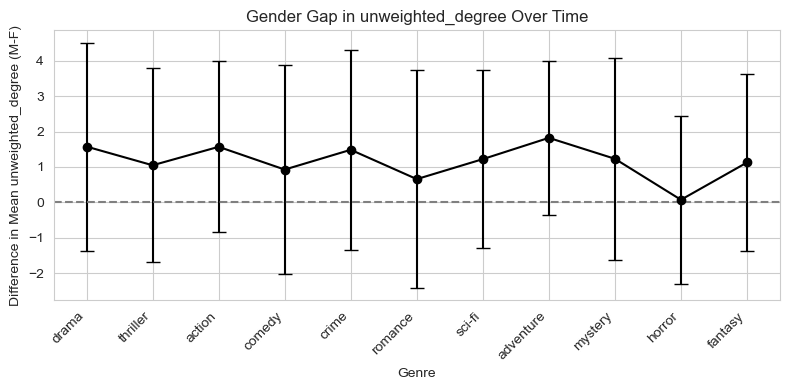

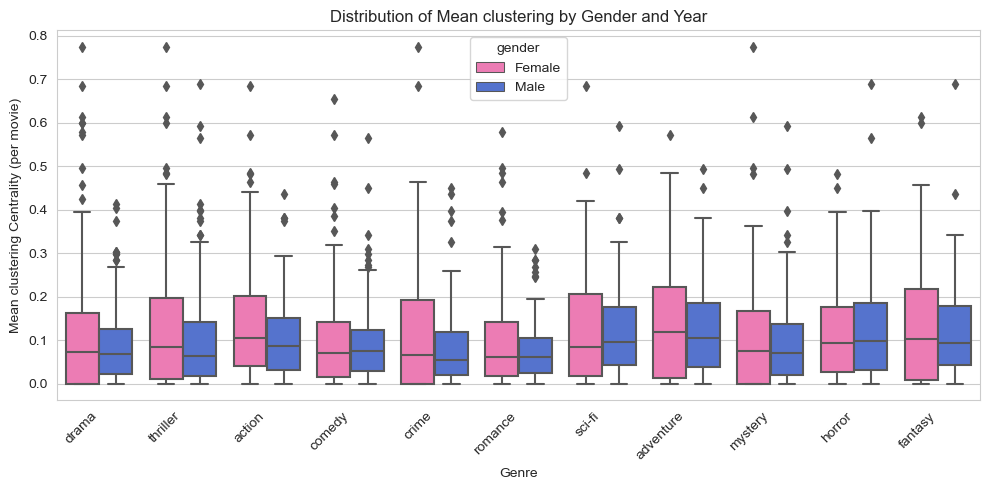

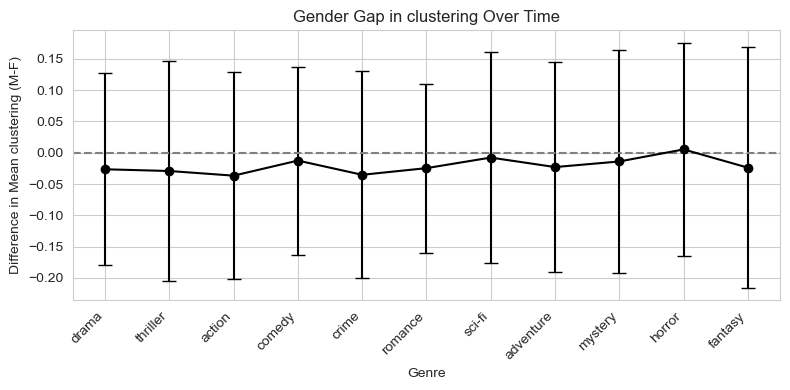

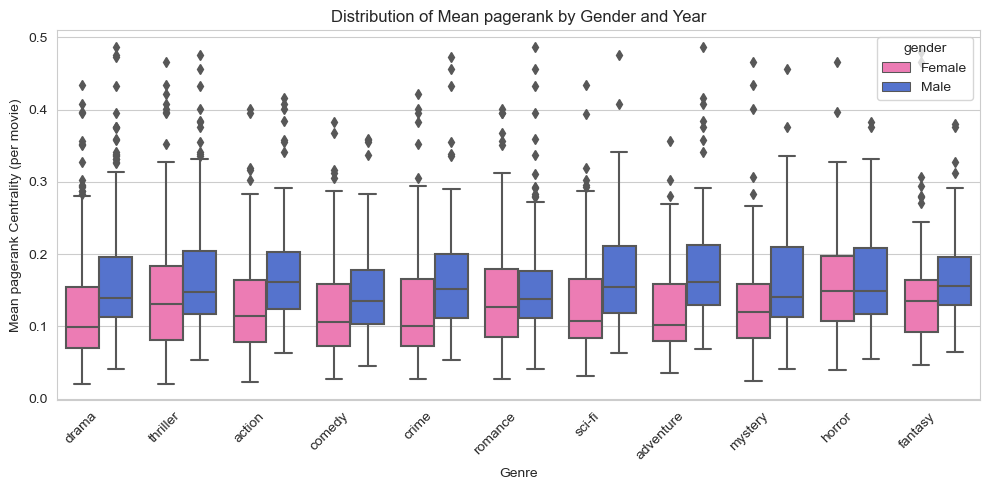

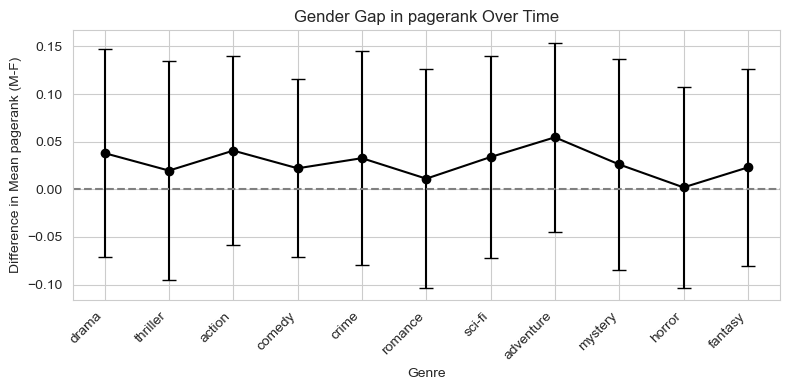

In [43]:
metrics = ['closeness', 'betweenness', 'degree', 'unweighted_degree', 'clustering', 'pagerank']
base_genre_order = ['drama', 'thriller', 'action', 'comedy', 'crime', 'romance','sci-fi',
                                            'adventure', 'mystery', 'horror', 'fantasy']
for met in metrics:
    male_female_genre_comp(df_main_genres, met, genre_order = base_genre_order)

In [44]:
import pandas as pd
from scipy.stats import ttest_ind

metrics = ['closeness', 'betweenness', 'degree', 'unweighted_degree', 'clustering', 'pagerank']
genre_order = [
    'drama', 'thriller', 'action', 'comedy', 'crime', 'romance',
    'sci-fi', 'adventure', 'mystery', 'horror', 'fantasy'
]

pvals = {metric: {} for metric in metrics}

for metric in metrics:
    for genre in genre_order:
        f_vals = df_main_genres[df_main_genres['genre'] == genre][f'{metric}_f_mean'].dropna()
        m_vals = df_main_genres[df_main_genres['genre'] == genre][f'{metric}_m_mean'].dropna()
        if len(f_vals) > 1 and len(m_vals) > 1:
            t, p = ttest_ind(m_vals, f_vals, equal_var=False, nan_policy='omit')
            pvals[metric][genre] = p
        else:
            pvals[metric][genre] = None

summary_df = pd.DataFrame(pvals).T[genre_order]

def signif_marker(p):
    if p is None:
        return "N/A"
    elif p < 0.05:
        return "✓"
    else:
        return "✗"

summary_display = summary_df.applymap(signif_marker)

print("Significance summary (✓ = p < 0.05, ✗ = not significant, N/A = insufficient data):")
display(summary_display)


Significance summary (✓ = p < 0.05, ✗ = not significant, N/A = insufficient data):


C:\Users\deeth\AppData\Local\Temp\ipykernel_32512\3143146293.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  summary_display = summary_df.applymap(signif_marker)


drama thriller action comedy crime romance sci-fi adventure  \
closeness             ✓        ✓      ✓      ✗     ✗       ✗      ✗         ✓   
betweenness           ✓        ✓      ✓      ✓     ✓       ✓      ✓         ✓   
degree                ✓        ✓      ✓      ✓     ✓       ✗      ✓         ✓   
unweighted_degree     ✓        ✓      ✓      ✓     ✓       ✓      ✓         ✓   
clustering            ✓        ✓      ✓      ✗     ✓       ✓      ✗         ✗   
pagerank              ✓        ✓      ✓      ✓     ✓       ✗      ✓         ✓   

                  mystery horror fantasy  
closeness               ✗      ✗       ✗  
betweenness             ✓      ✗       ✓  
degree                  ✓      ✗       ✗  
unweighted_degree       ✓      ✗       ✓  
clustering              ✗      ✗       ✗  
pagerank                ✓      ✗       ✗

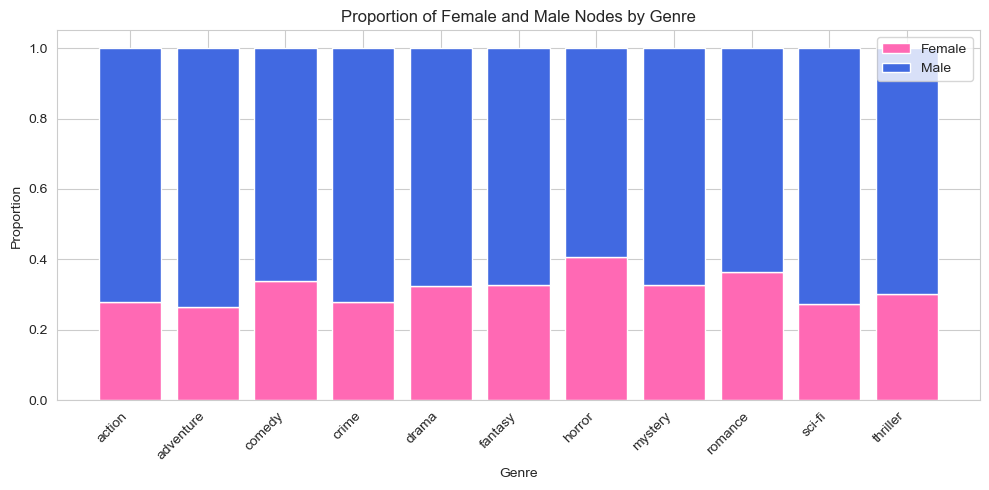

In [45]:
by_genre = df_main_genres.groupby('genre').agg({
    'n_female': 'sum',
    'n_male': 'sum',
    'pct_known_gender': 'mean'
}).reset_index()

by_genre['total'] = by_genre['n_female'] + by_genre['n_male']
by_genre['prop_female'] = by_genre['n_female'] / by_genre['total']
by_genre['prop_male'] = by_genre['n_male'] / by_genre['total']

plt.figure(figsize=(10,5))
plt.bar(by_genre['genre'], by_genre['prop_female'], label='Female', color='hotpink')
plt.bar(by_genre['genre'], by_genre['prop_male'], bottom=by_genre['prop_female'], label='Male', color='royalblue')
plt.xlabel('Genre')
plt.ylabel('Proportion')
plt.title('Proportion of Female and Male Nodes by Genre')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


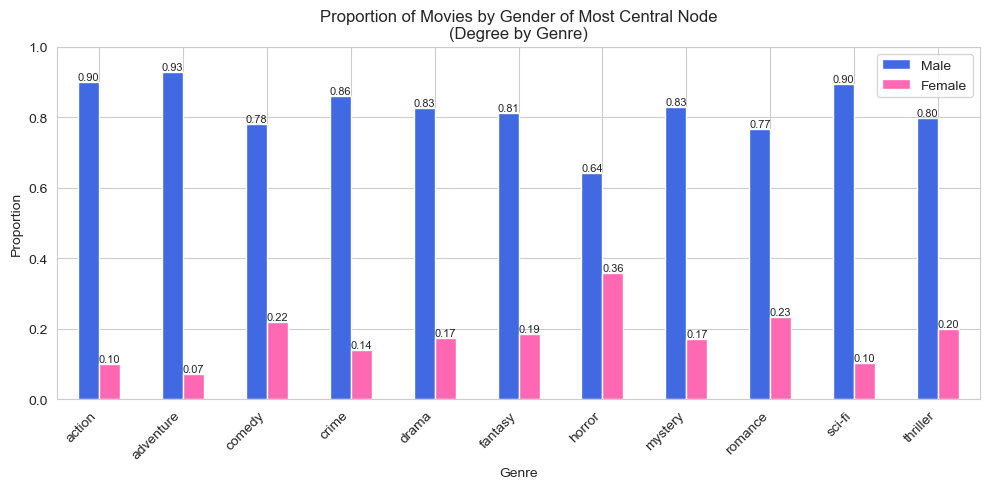

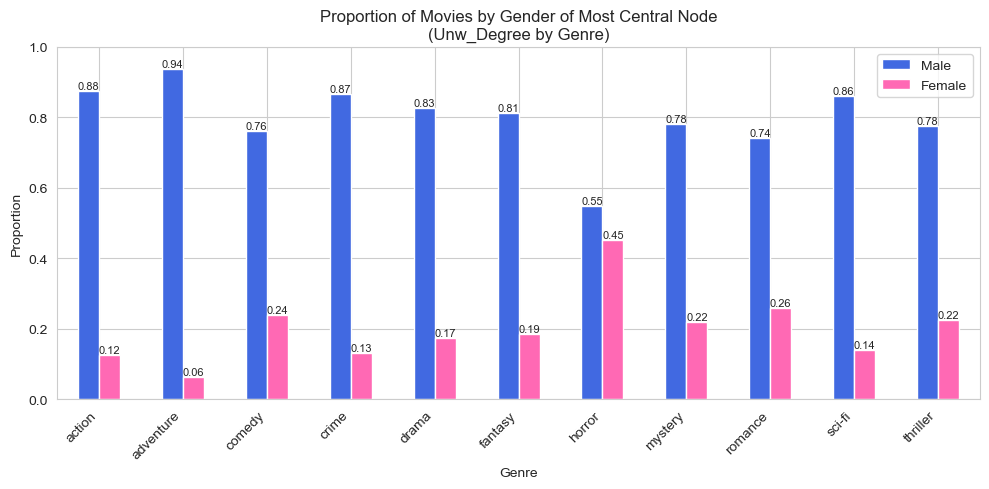

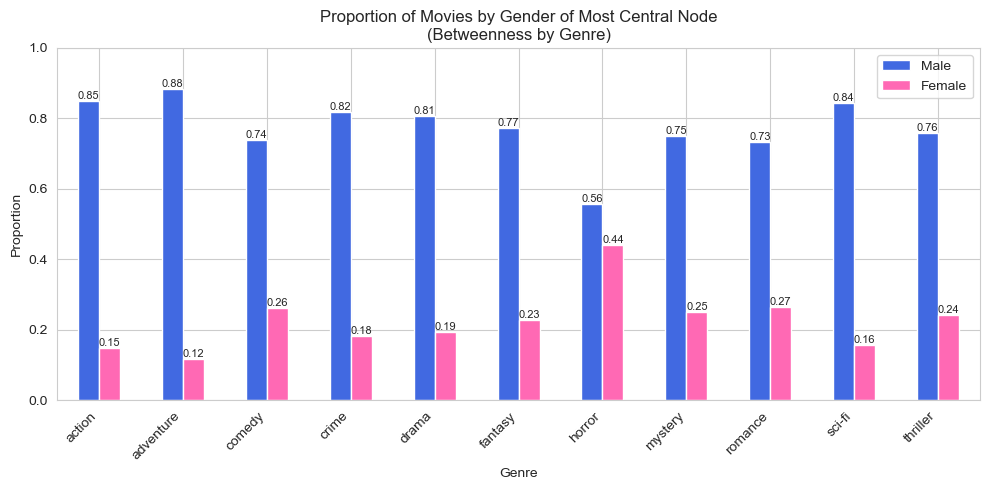

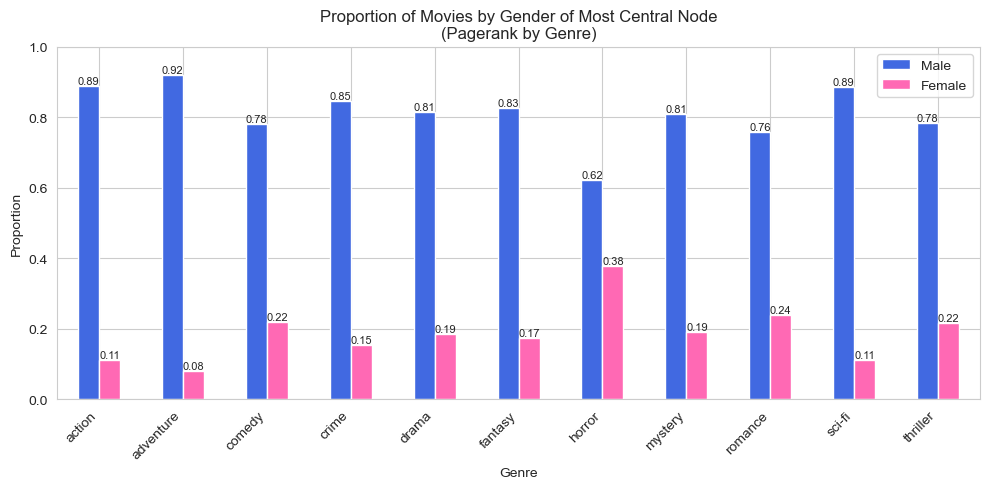

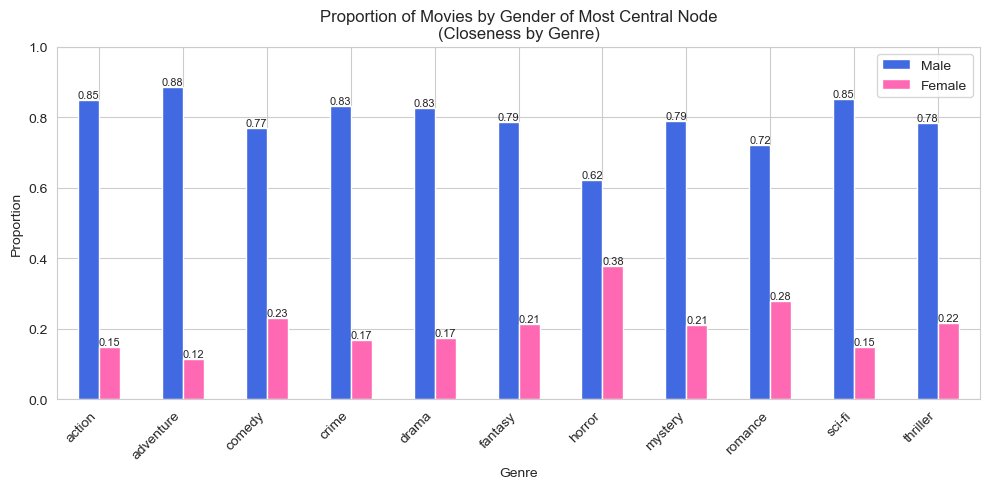

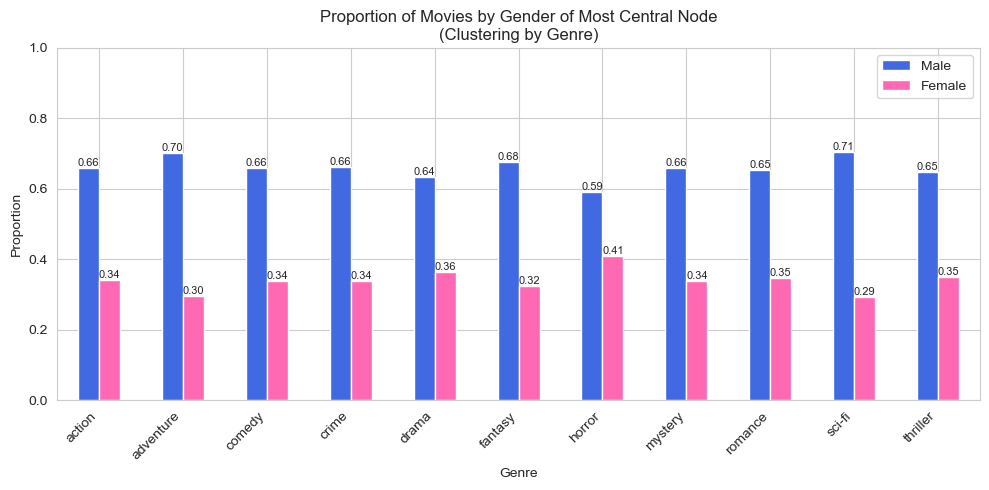

In [46]:
centrality_cols = [
    'top_degree_gender',
    'top_unw_degree_gender',
    'top_betweenness_gender',
    'top_pagerank_gender',
    'top_closeness_gender',
    'top_clustering_gender'
]

for col in centrality_cols:
    gender_counts = (
        df_main_genres.groupby(['genre', col])
        .size()
        .unstack(fill_value=0)[['m', 'f']]
    )
    prop = gender_counts.div(gender_counts.sum(axis=1), axis=0)
    ax = prop.plot(kind='bar', figsize=(10,5), color=['royalblue','hotpink'])
    plt.title(f"Proportion of Movies by Gender of Most Central Node\n({col.replace('top_','').replace('_gender','').title()} by Genre)")
    plt.xlabel('Genre')
    plt.ylabel('Proportion')
    plt.ylim(0,1)
    plt.xticks(rotation=45, ha='right')
    plt.legend(['Male','Female'], loc='upper right')
    for p in ax.patches:
        height = p.get_height()
        if not np.isnan(height):
            ax.annotate(f"{height:.2f}", (p.get_x() + p.get_width() / 2, height),
                        ha='center', va='bottom', fontsize=8)
    plt.tight_layout()
    plt.show()

In [47]:
df_metrics['genre_combo'] = df_metrics['genres'].apply(lambda x: ', '.join(sorted(x)) if isinstance(x, list) else x)

top_combos = (
    df_metrics['genre_combo']
    .value_counts()
    .head(10)
    .index
    .tolist()
)

In [48]:
df_top_combos = df_metrics[df_metrics['genre_combo'].isin(top_combos)].copy()
df_top_combos = df_top_combos.rename(columns={'genre_combo': 'genre'})

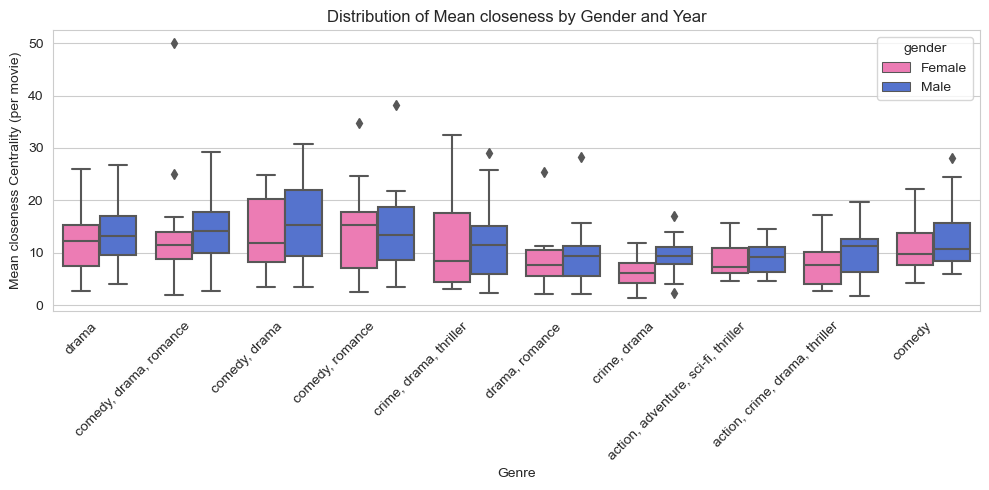

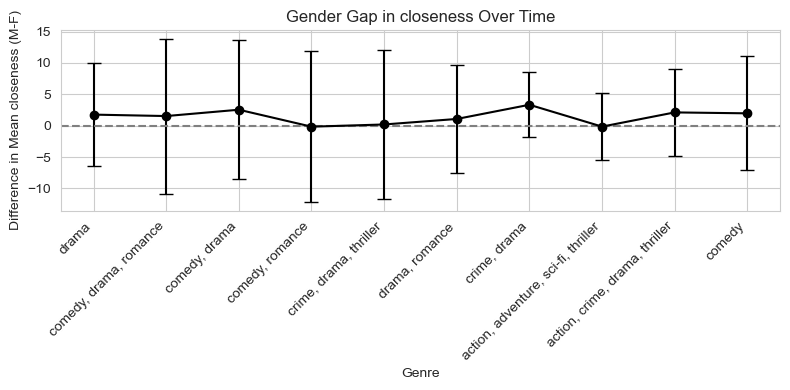

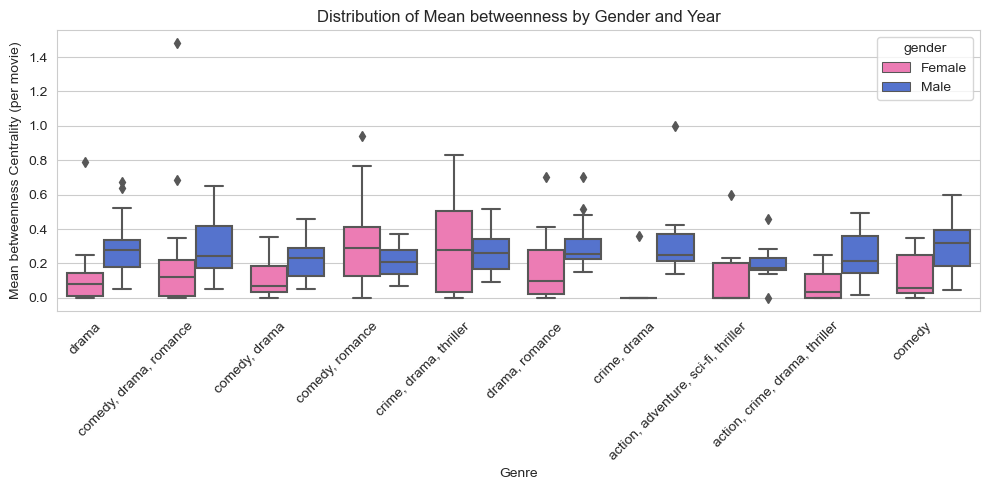

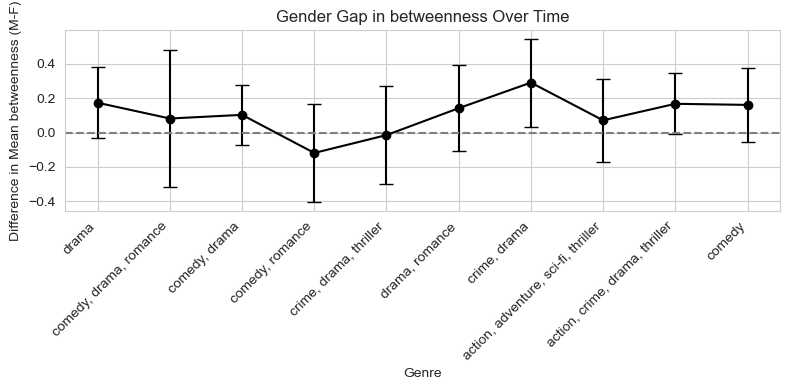

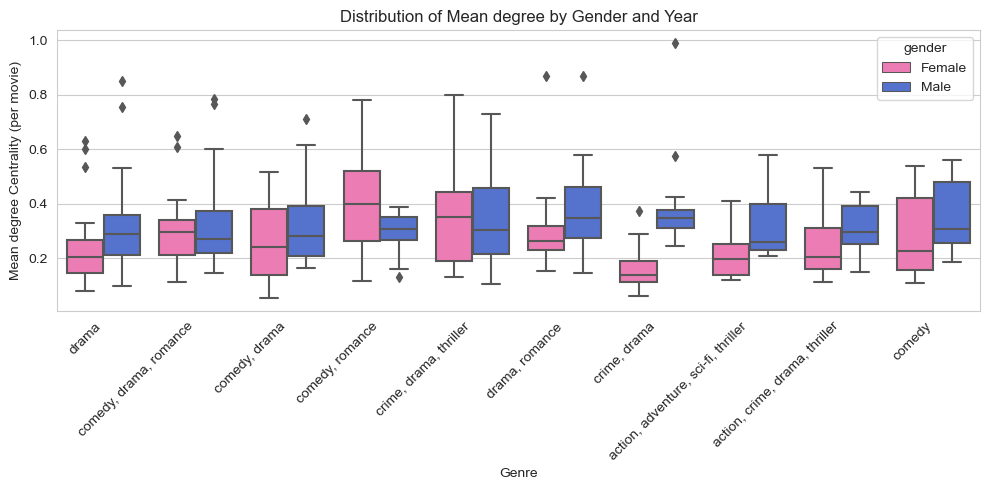

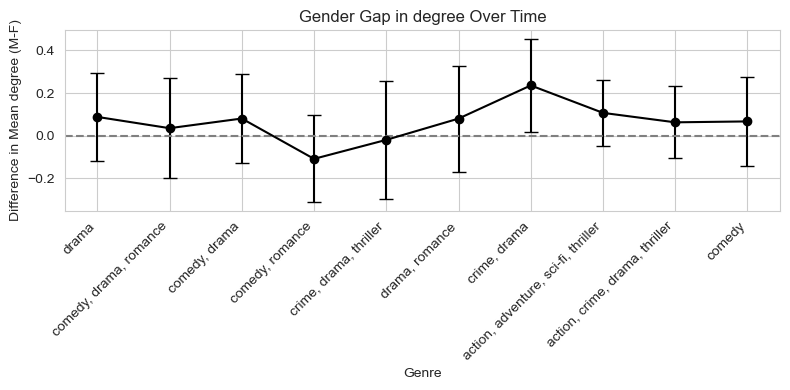

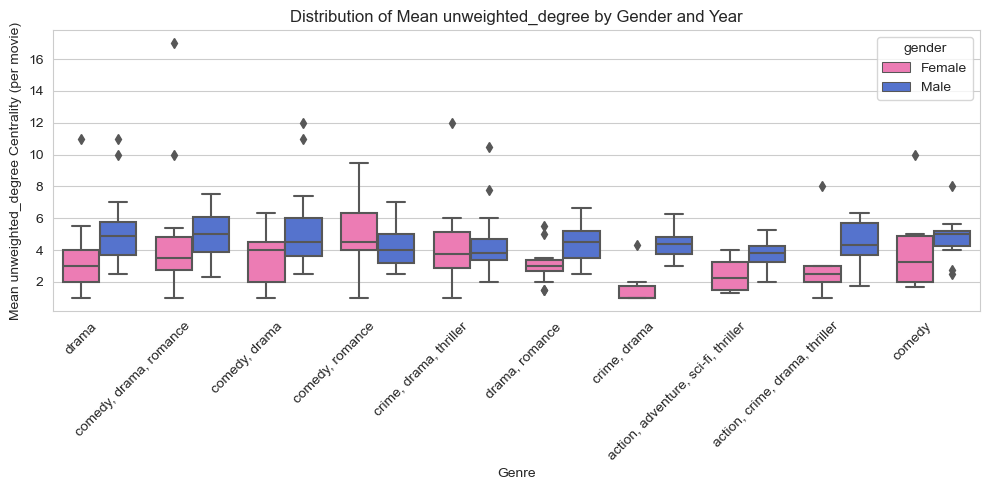

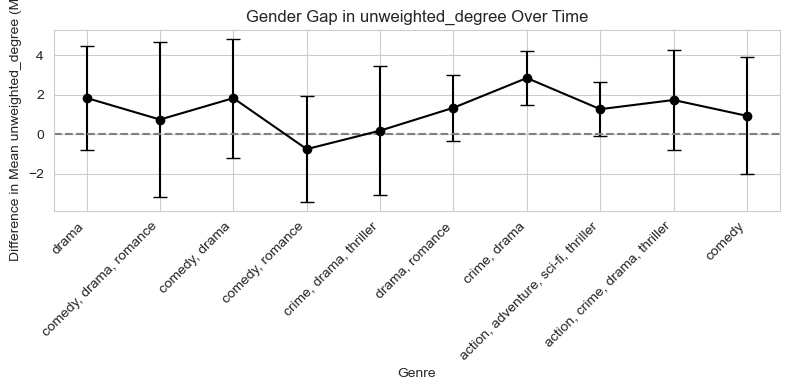

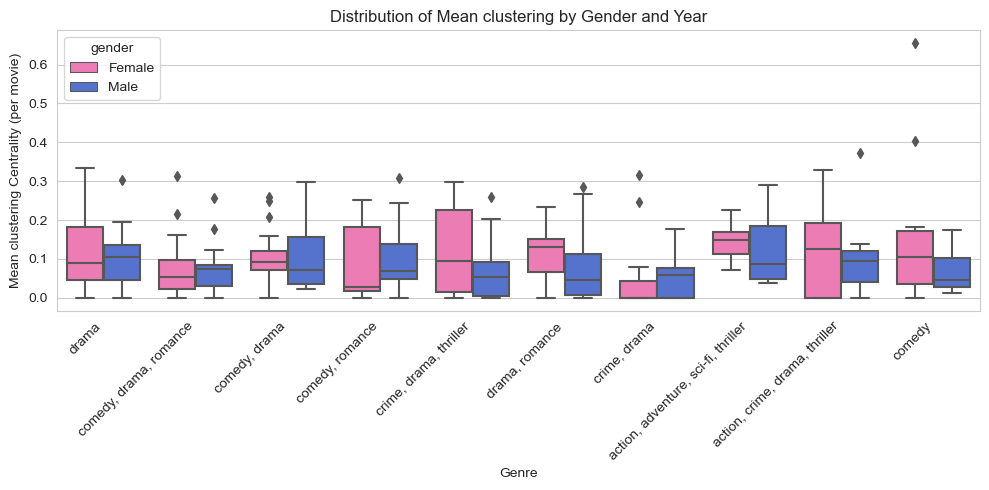

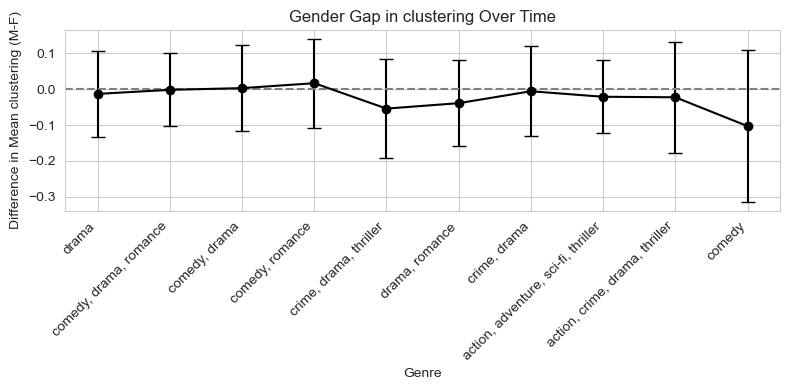

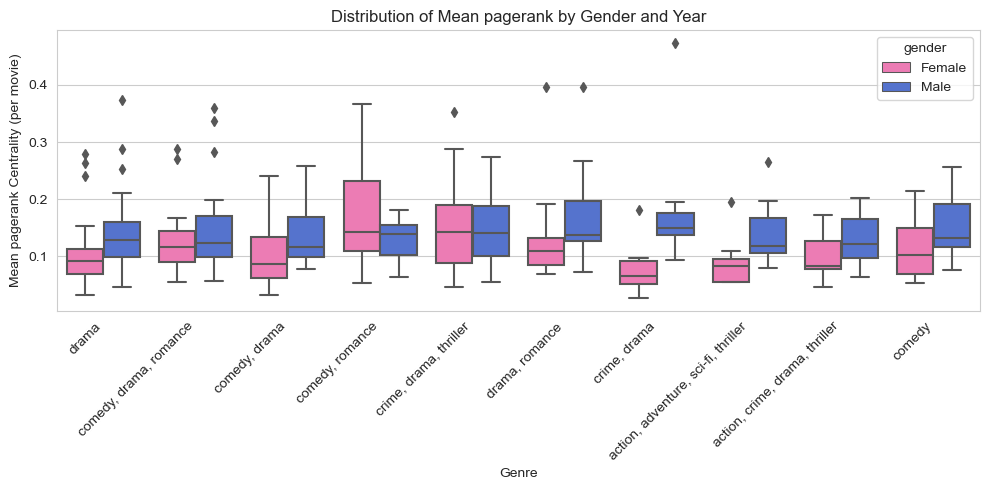

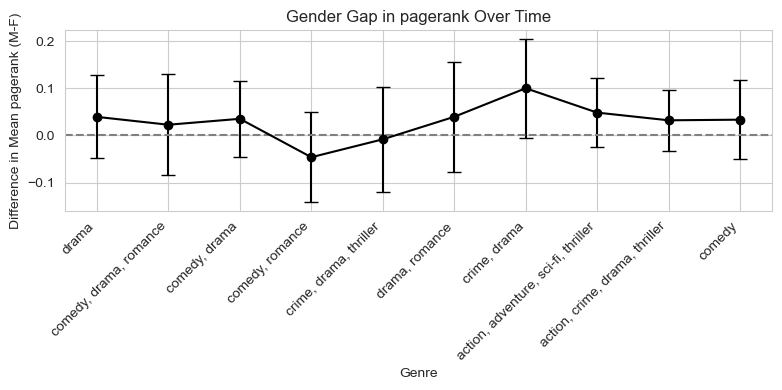

In [49]:
metrics = ['closeness', 'betweenness', 'degree', 'unweighted_degree', 'clustering', 'pagerank']

for met in metrics:
    male_female_genre_comp(df_top_combos, met, genre_order = top_combos)

In [50]:
def male_female_extreme_genre_combos(df, metric):
    if 'genre_combo' not in df.columns or 'genres_list' not in df.columns:
        df = df.copy()
        df['genres_list'] = df['genres'].apply(lambda x: x if isinstance(x, list) else eval(x))
        df['genre_combo'] = df['genres_list'].apply(lambda x: ', '.join(sorted(x)))

    df = df[df['genres_list'].apply(lambda x: len(x) <= 2)]

    grouped = (
        df.groupby('genre_combo')
        .agg({
            f'{metric}_f_mean': ['mean', 'std', 'count'],
            f'{metric}_m_mean': ['mean', 'std', 'count'],
        })
    )
    grouped.columns = ['_'.join(col) for col in grouped.columns]
    grouped = grouped.reset_index()
    grouped['gap'] = grouped[f'{metric}_m_mean_mean'] - grouped[f'{metric}_f_mean_mean']
    grouped['n_movies'] = grouped[[f'{metric}_f_mean_count', f'{metric}_m_mean_count']].max(axis=1)

    grouped = grouped[grouped['n_movies'] >= 2]

    top5 = grouped.sort_values('gap', ascending=False).head(5)
    bottom5 = grouped.sort_values('gap', ascending=True).head(5)
    selected = pd.concat([top5, bottom5])
    combo_order = selected['genre_combo'].tolist()

    df_selected = df[df['genre_combo'].isin(combo_order)].copy()
    df_long = df_selected.melt(
        id_vars=['genre_combo'],
        value_vars=[f'{metric}_f_mean', f'{metric}_m_mean'],
        var_name='gender', value_name=f'mean_{metric}'
    )
    df_long['gender'] = df_long['gender'].map({
        f'{metric}_f_mean': 'Female',
        f'{metric}_m_mean': 'Male'
    })

    import matplotlib.pyplot as plt
    import seaborn as sns
    plt.figure(figsize=(14,5))
    sns.boxplot(
        x='genre_combo',
        y=f'mean_{metric}',
        hue='gender',
        data=df_long,
        palette=['hotpink','royalblue'],
        order=combo_order
    )
    plt.xlabel('Genre Combination')
    plt.ylabel(f'Mean {metric} Centrality (per movie)')
    plt.title(f'Distribution of Mean {metric} by Gender\nTop 5 and Bottom 5 Genre Gaps (min 2 movies)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    selected = selected.set_index('genre_combo').reindex(combo_order).reset_index()
    diff = selected[f'{metric}_m_mean_mean'] - selected[f'{metric}_f_mean_mean']
    err = np.sqrt(selected[f'{metric}_m_mean_std']**2 + selected[f'{metric}_f_mean_std']**2)

    plt.figure(figsize=(14,4))
    plt.errorbar(selected['genre_combo'], diff, yerr=err, fmt='o-', color='black', capsize=5)
    plt.axhline(0, color='gray', linestyle='--')
    plt.xlabel('Genre Combination')
    plt.ylabel(f'Difference in Mean {metric} (M-F)')
    plt.title(f'Gender Gap in {metric} (Top 5 and Bottom 5 Genre Combos, min 2 movies)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

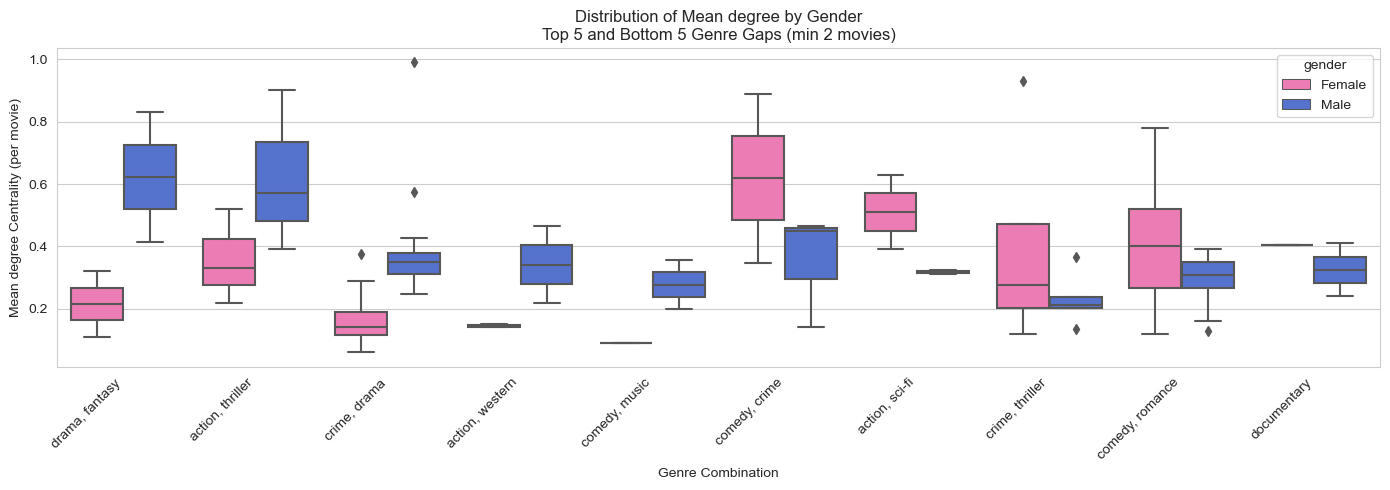

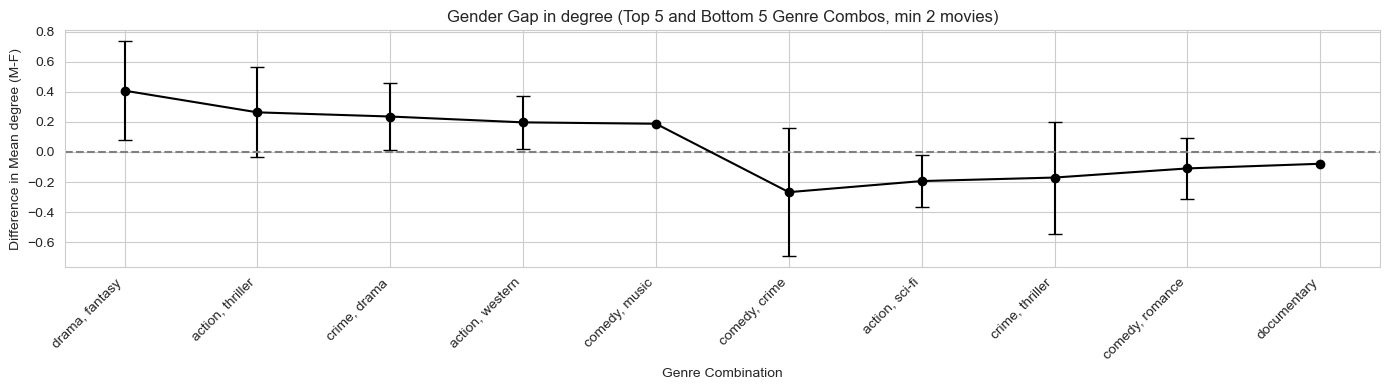

In [51]:
male_female_extreme_genre_combos(df_metrics, 'degree')

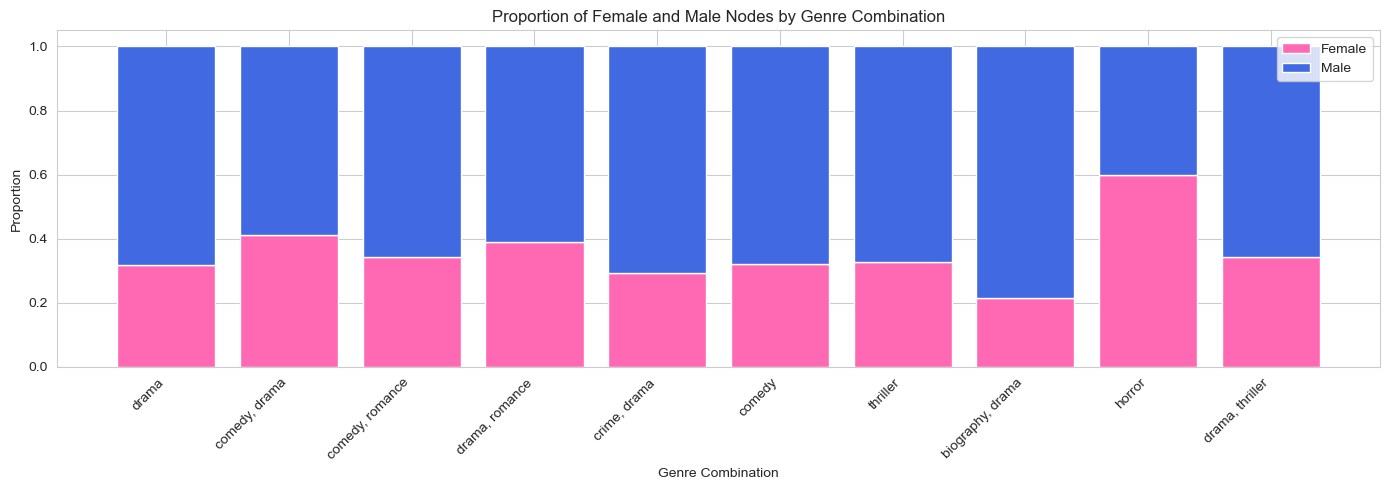

In [52]:
df_metrics['genres_list'] = df_metrics['genres'].apply(lambda x: x if isinstance(x, list) else eval(x))
df_metrics['genre_combo'] = df_metrics['genres_list'].apply(lambda x: ', '.join(sorted(x)))

combo_counts = df_metrics['genre_combo'].value_counts()
valid_combos = combo_counts[combo_counts >= 2].index.tolist()

df_combo = df_metrics[df_metrics['genre_combo'].isin(valid_combos) & (df_metrics['genres_list'].apply(lambda x: len(x) <= 2))]

by_combo = df_combo.groupby('genre_combo').agg({
    'n_female': 'sum',
    'n_male': 'sum',
    'pct_known_gender': 'mean'
}).reset_index()
by_combo['total'] = by_combo['n_female'] + by_combo['n_male']
by_combo['prop_female'] = by_combo['n_female'] / by_combo['total']
by_combo['prop_male'] = by_combo['n_male'] / by_combo['total']

top_n = 10
combo_order = by_combo.sort_values('total', ascending=False)['genre_combo'].head(top_n).tolist()
by_combo_top = by_combo[by_combo['genre_combo'].isin(combo_order)].set_index('genre_combo').reindex(combo_order).reset_index()

import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))
plt.bar(by_combo_top['genre_combo'], by_combo_top['prop_female'], label='Female', color='hotpink')
plt.bar(by_combo_top['genre_combo'], by_combo_top['prop_male'], bottom=by_combo_top['prop_female'], label='Male', color='royalblue')
plt.xlabel('Genre Combination')
plt.ylabel('Proportion')
plt.title('Proportion of Female and Male Nodes by Genre Combination')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


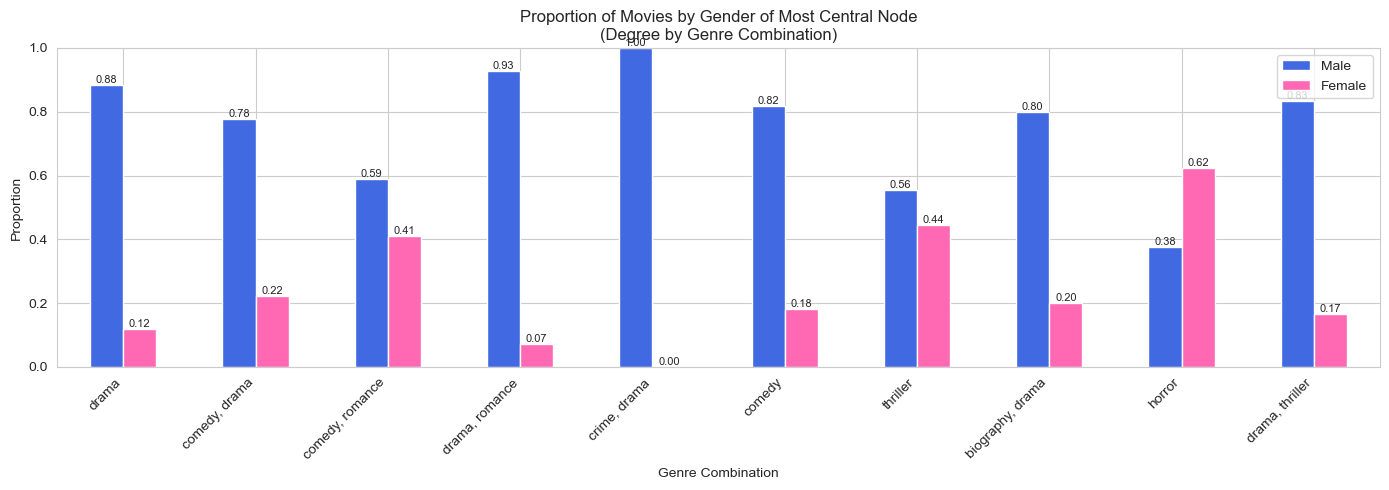

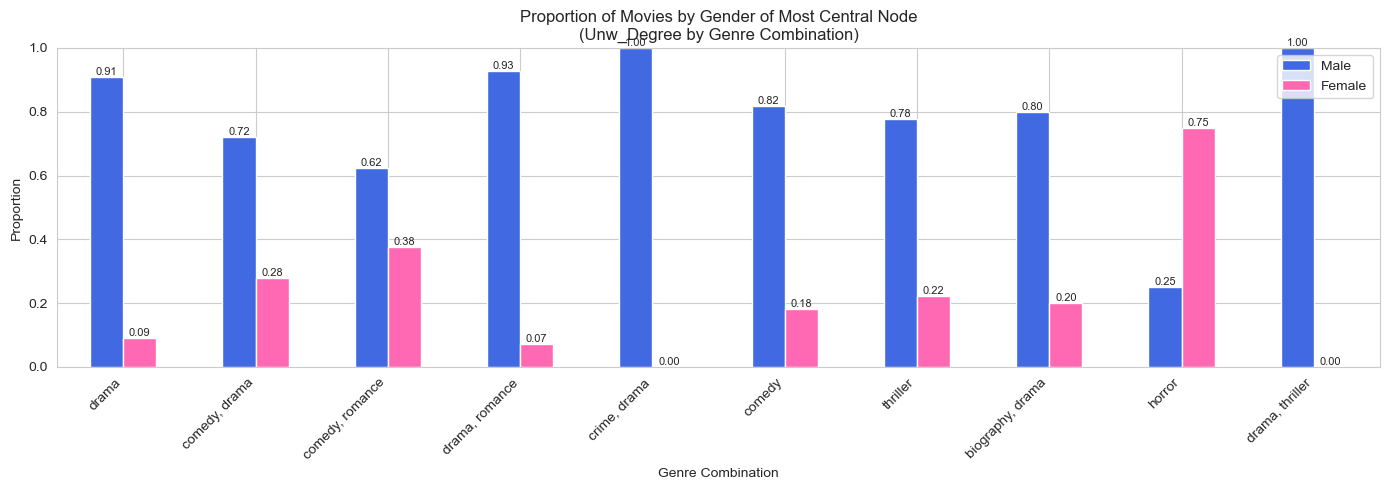

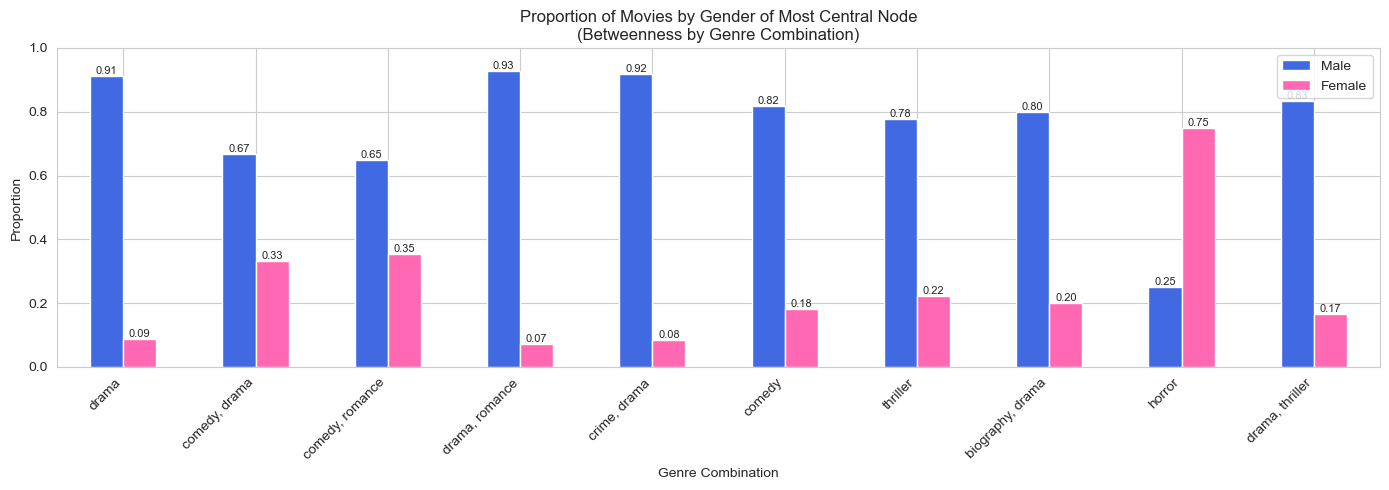

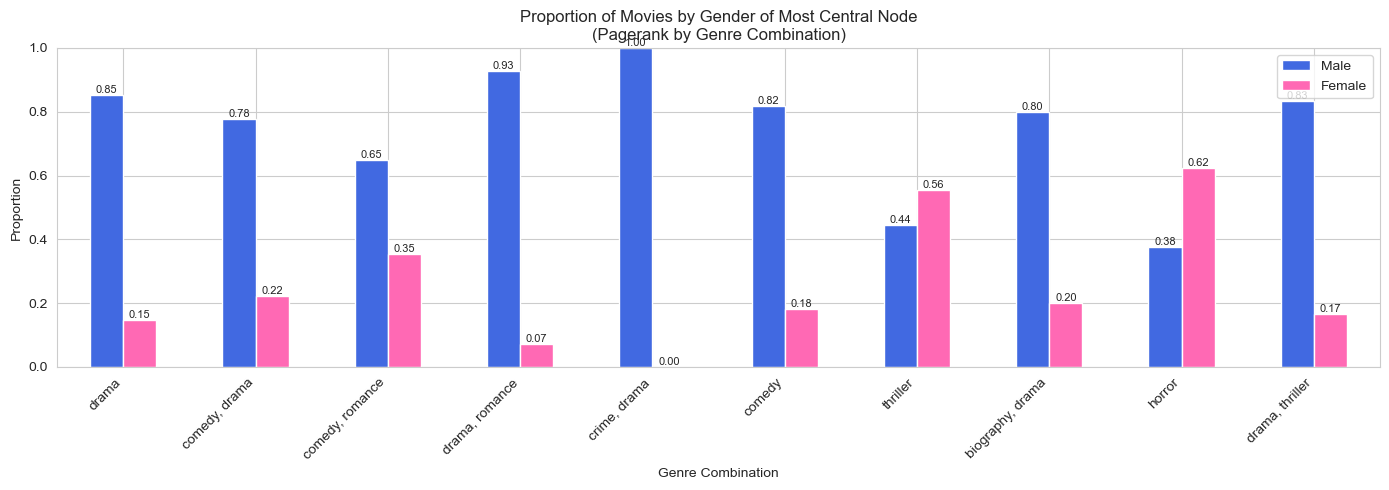

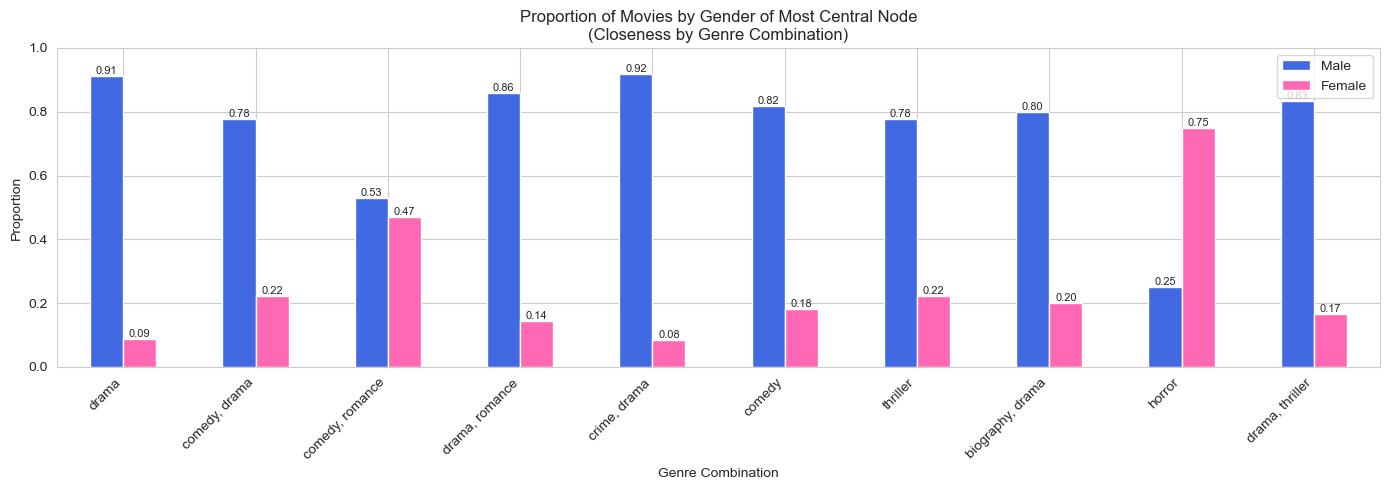

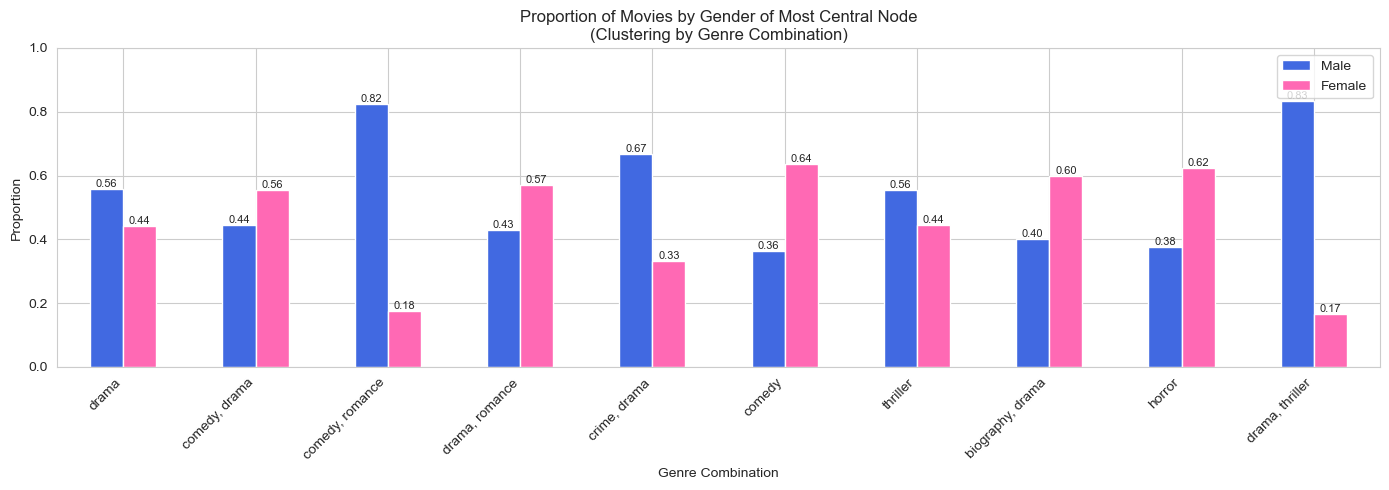

In [53]:
centrality_cols = [
    'top_degree_gender',
    'top_unw_degree_gender',
    'top_betweenness_gender',
    'top_pagerank_gender',
    'top_closeness_gender',
    'top_clustering_gender'
]

for col in centrality_cols:
    gender_counts = (
        df_combo.groupby(['genre_combo', col])
        .size()
        .unstack(fill_value=0)[['m', 'f']]
    )
    gender_counts = gender_counts.reindex(combo_order)
    prop = gender_counts.div(gender_counts.sum(axis=1), axis=0)
    ax = prop.plot(kind='bar', figsize=(14,5), color=['royalblue','hotpink'])
    plt.title(f"Proportion of Movies by Gender of Most Central Node\n({col.replace('top_','').replace('_gender','').title()} by Genre Combination)")
    plt.xlabel('Genre Combination')
    plt.ylabel('Proportion')
    plt.ylim(0,1)
    plt.xticks(rotation=45, ha='right')
    plt.legend(['Male','Female'], loc='upper right')
    for p in ax.patches:
        height = p.get_height()
        if not np.isnan(height):
            ax.annotate(f"{height:.2f}", (p.get_x() + p.get_width() / 2, height),
                        ha='center', va='bottom', fontsize=8)
    plt.tight_layout()
    plt.show()


### Bechdel Test Analysis

In [54]:
df_metrics['bechdel_score'] = pd.to_numeric(df_metrics['bechdel_score'], errors='coerce')
df_bechdel = df_metrics[df_metrics['bechdel_score'].isin([0,1,2,3])].copy()

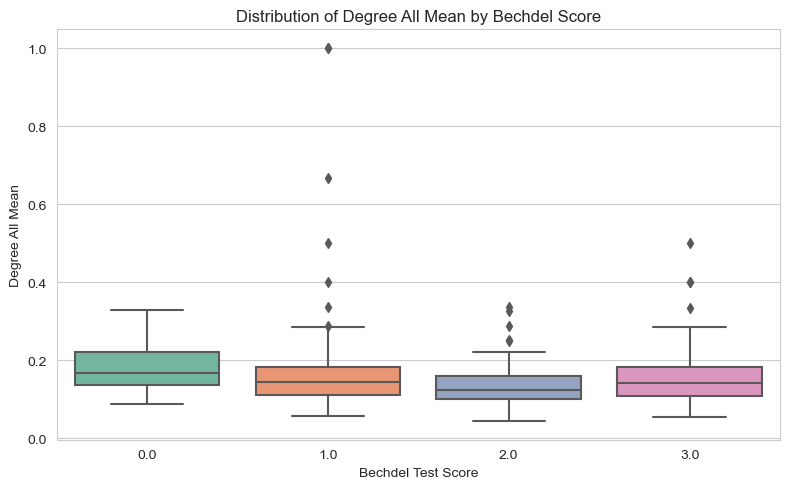

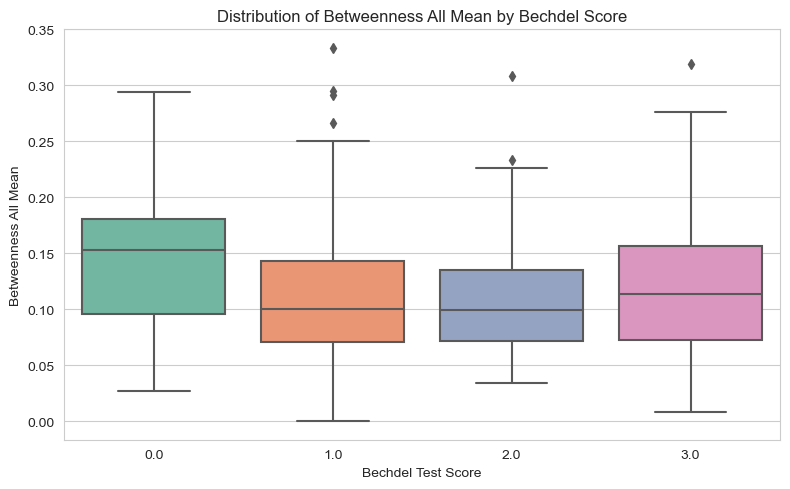

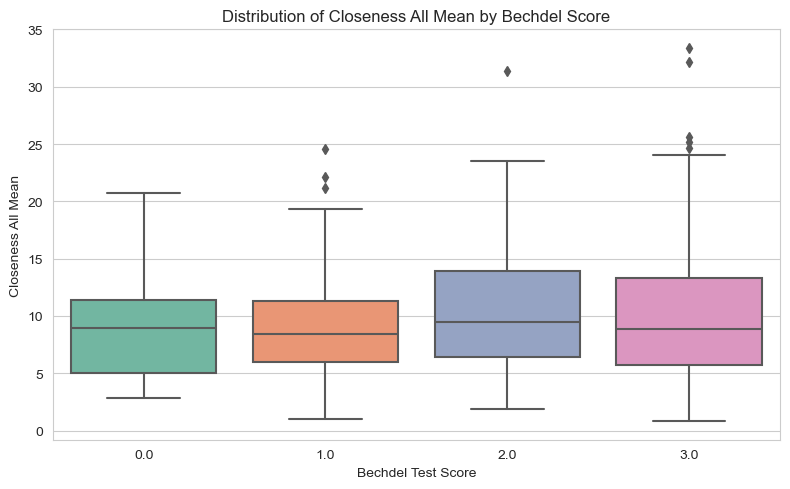

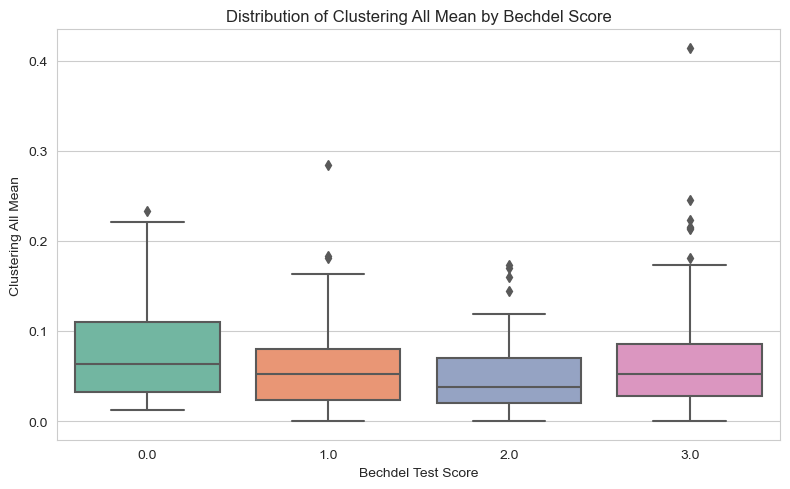

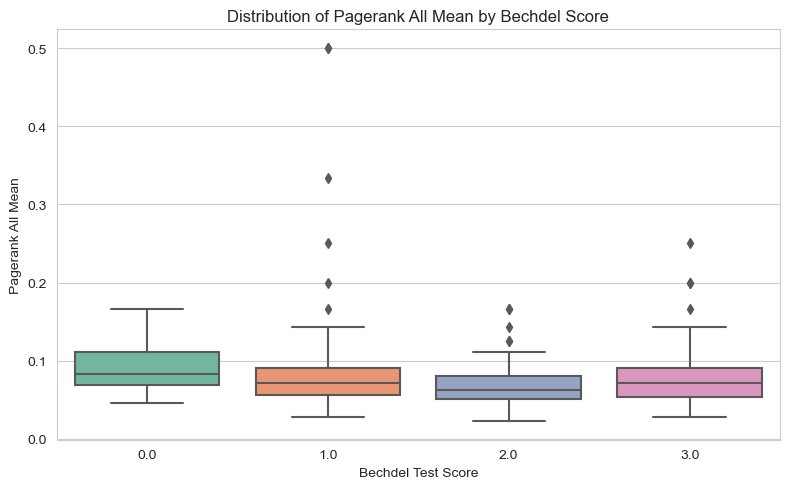

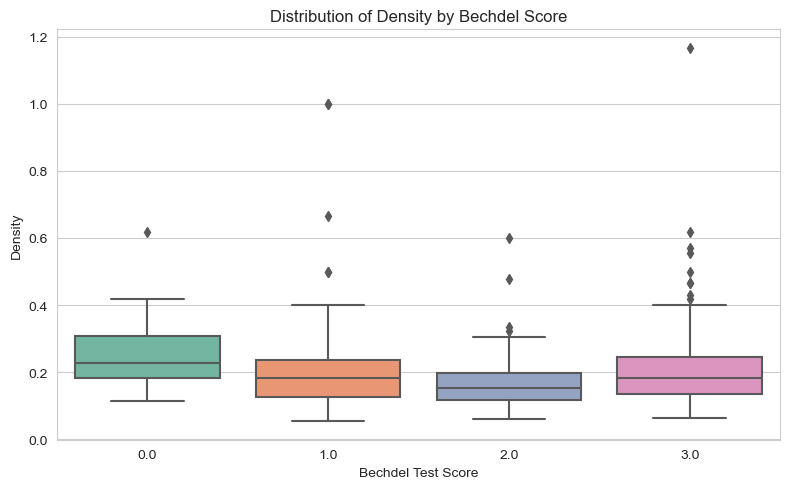

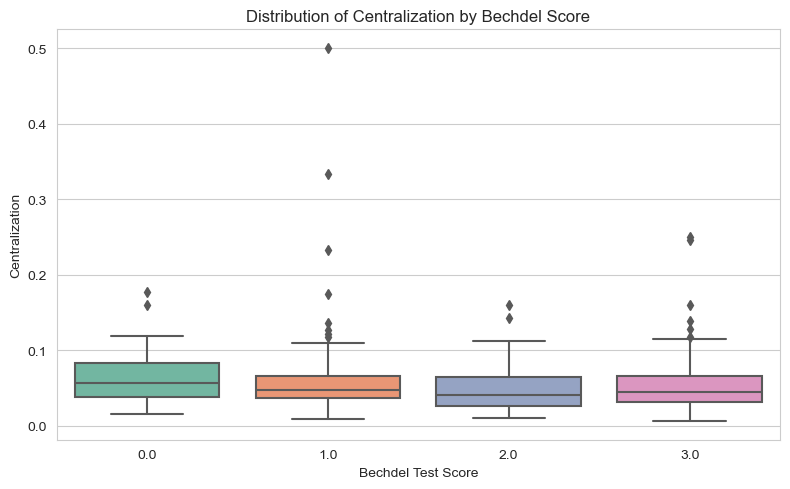

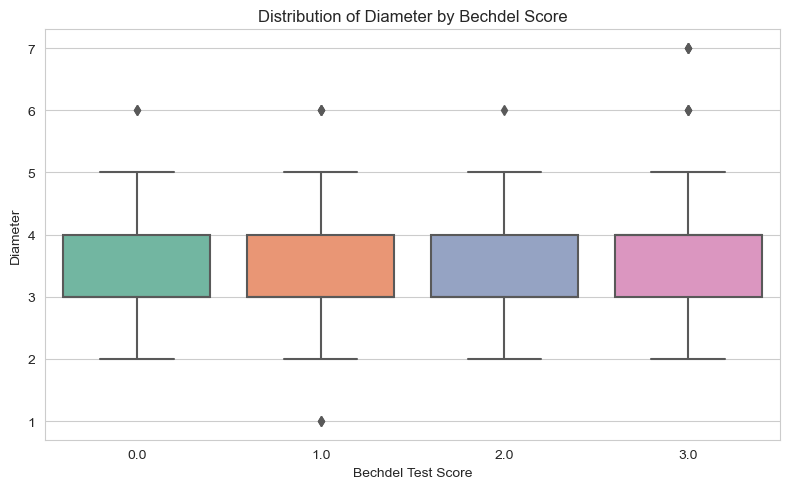

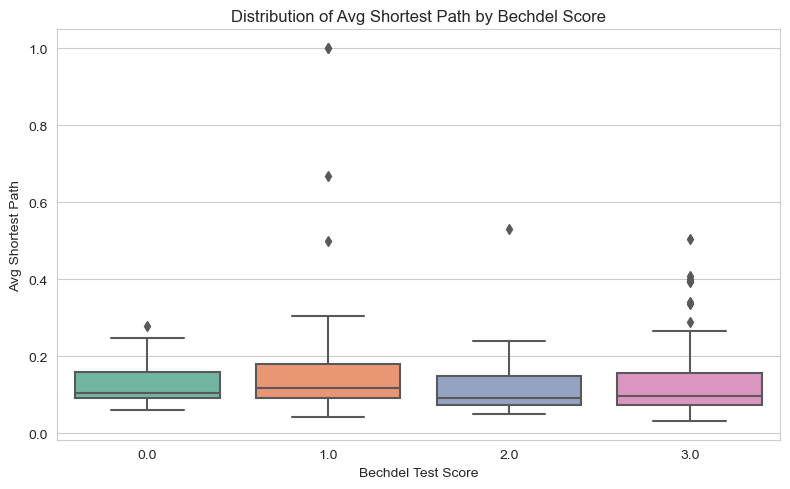

In [55]:
metrics_to_compare = [
    'degree_all_mean',
    'betweenness_all_mean',
    'closeness_all_mean',
    'clustering_all_mean',
    'pagerank_all_mean',
    'density',
    'centralization',
    'diameter',
    'avg_shortest_path'
]

for metric in metrics_to_compare:
    plt.figure(figsize=(8,5))
    sns.boxplot(
        x='bechdel_score',
        y=metric,
        data=df_bechdel,
        palette='Set2'
    )
    plt.xlabel('Bechdel Test Score')
    plt.ylabel(metric.replace('_', ' ').title())
    plt.title(f'Distribution of {metric.replace("_", " ").title()} by Bechdel Score')
    plt.tight_layout()
    plt.show()

In [56]:
from scipy.stats import ttest_ind
import pandas as pd
from itertools import combinations

bechdel_scores = [0, 1, 2, 3]
metrics_to_compare = [
    'degree_all_mean',
    'betweenness_all_mean',
    'closeness_all_mean',
    'clustering_all_mean',
    'pagerank_all_mean',
    'density',
    'centralization',
    'diameter',
    'avg_shortest_path'
]

# Store results in a MultiIndex DataFrame
index = pd.MultiIndex.from_product(
    [metrics_to_compare, [f"{a} vs {b}" for a, b in combinations(bechdel_scores, 2)]],
    names=["metric", "comparison"]
)
ttest_table = pd.DataFrame(index=index, columns=["t", "p", "signif"])

for metric in metrics_to_compare:
    for a, b in combinations(bechdel_scores, 2):
        vals_a = df_bechdel[df_bechdel['bechdel_score'] == a][metric].dropna()
        vals_b = df_bechdel[df_bechdel['bechdel_score'] == b][metric].dropna()
        if len(vals_a) > 1 and len(vals_b) > 1:
            t, p = ttest_ind(vals_a, vals_b, equal_var=False, nan_policy='omit')
            signif = "✓" if p < 0.05 else "✗"
            ttest_table.loc[(metric, f"{a} vs {b}"), :] = [t, p, signif]
        else:
            ttest_table.loc[(metric, f"{a} vs {b}"), :] = [None, None, "N/A"]

# Display significance only
ttest_signif = ttest_table["signif"].unstack(level=0)
print("Significance summary (✓ = p < 0.05, ✗ = not significant, N/A = insufficient data):")
display(ttest_signif)

# (Optional) Show rounded p-values
print("\nP-values (rounded):")
display(ttest_table["p"].astype(float).round(3).unstack(level=0))


Significance summary (✓ = p < 0.05, ✗ = not significant, N/A = insufficient data):


metric     avg_shortest_path betweenness_all_mean centralization  \
comparison                                                         
0 vs 1                     ✗                    ✓              ✗   
0 vs 2                     ✗                    ✓              ✗   
0 vs 3                     ✗                    ✓              ✗   
1 vs 2                     ✗                    ✗              ✗   
1 vs 3                     ✗                    ✗              ✗   
2 vs 3                     ✗                    ✗              ✗   

metric     closeness_all_mean clustering_all_mean degree_all_mean density  \
comparison                                                                  
0 vs 1                      ✗                   ✓               ✗       ✗   
0 vs 2                      ✗                   ✓               ✓       ✓   
0 vs 3                      ✗                   ✗               ✓       ✓   
1 vs 2                      ✓                   ✗               ✓       ✗   
1 vs 3                      ✓                   ✗               ✗       ✗   
2 vs 3                      ✗                   ✗               ✗       ✓   

metric     diameter pagerank_all_mean  
comparison                             
0 vs 1            ✗                 ✗  
0 vs 2            ✗                 ✓  
0 vs 3            ✗                 ✓  
1 vs 2            ✗                 ✓  
1 vs 3            ✗                 ✗  
2 vs 3            ✗                 ✗


P-values (rounded):


metric      avg_shortest_path  betweenness_all_mean  centralization  \
comparison                                                            
0 vs 1                  0.111                 0.013           0.650   
0 vs 2                  0.552                 0.010           0.054   
0 vs 3                  0.764                 0.015           0.063   
1 vs 2                  0.058                 0.745           0.080   
1 vs 3                  0.059                 0.782           0.089   
2 vs 3                  0.681                 0.554           0.700   

metric      closeness_all_mean  clustering_all_mean  degree_all_mean  density  \
comparison                                                                      
0 vs 1                   0.934                0.025            0.411    0.053   
0 vs 2                   0.088                0.011            0.001    0.001   
0 vs 3                   0.190                0.110            0.009    0.034   
1 vs 2                   0.026                0.476            0.018    0.077   
1 vs 3                   0.040                0.213            0.149    0.949   
2 vs 3                   0.441                0.075            0.092    0.050   

metric      diameter  pagerank_all_mean  
comparison                               
0 vs 1         0.860              0.407  
0 vs 2         0.876              0.001  
0 vs 3         0.401              0.009  
1 vs 2         0.990              0.018  
1 vs 3         0.329              0.155  
2 vs 3         0.391              0.089

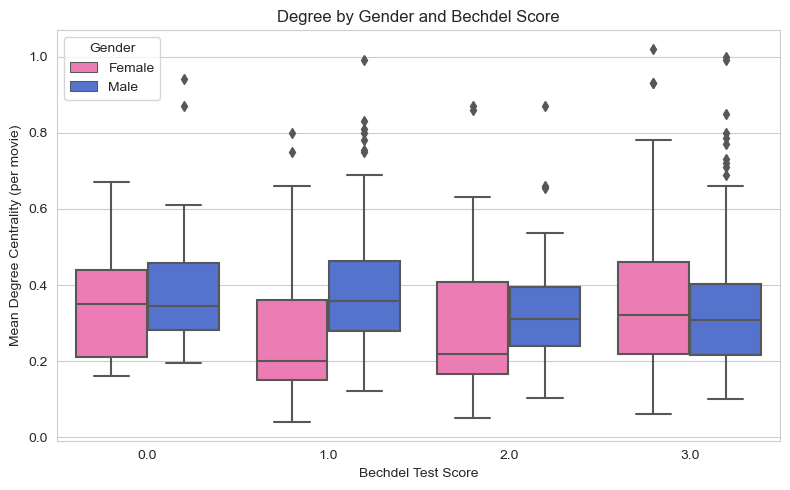

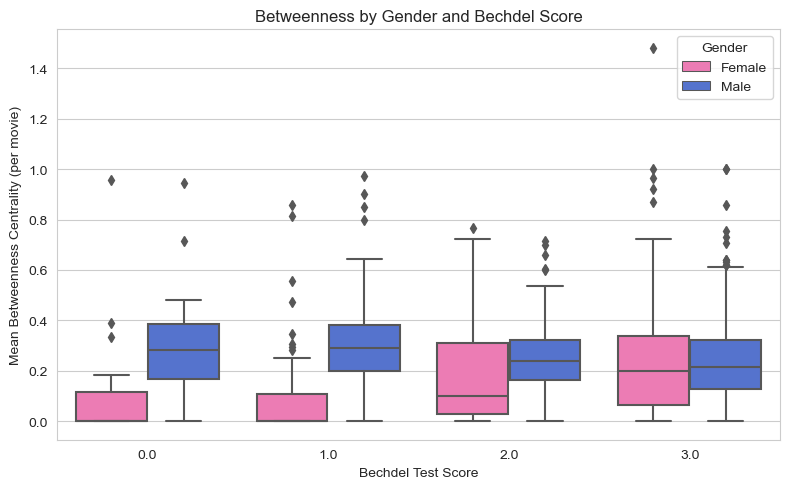

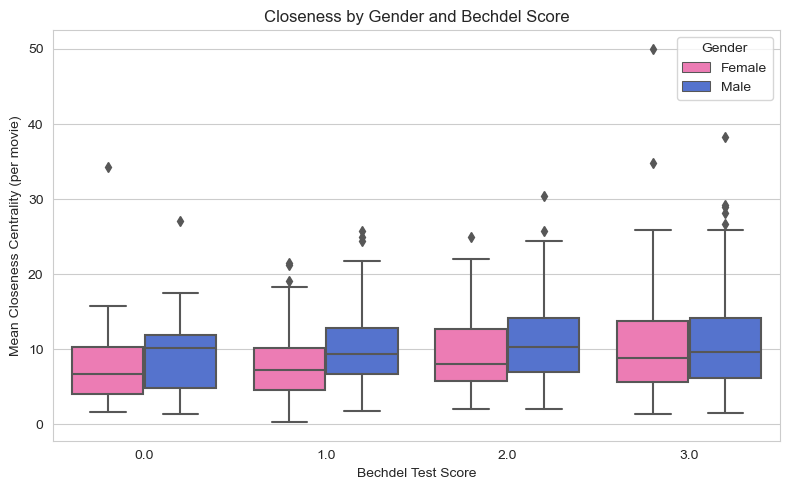

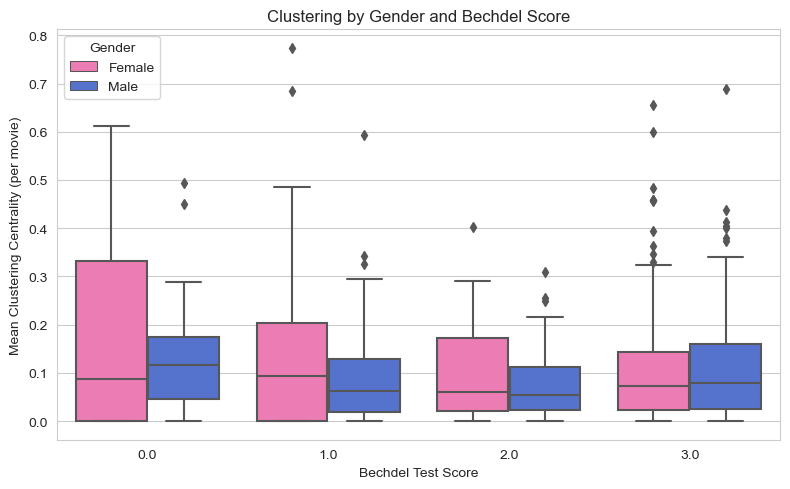

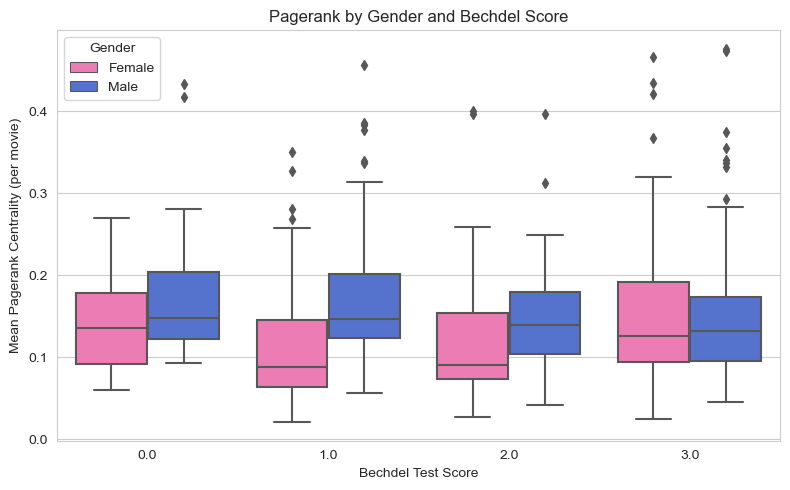

In [57]:
metrics_to_compare = [
    'degree',
    'betweenness',
    'closeness',
    'clustering',
    'pagerank'
]

for metric in metrics_to_compare:
    df_long = df_bechdel.melt(
        id_vars=['bechdel_score'],
        value_vars=[f'{metric}_f_mean', f'{metric}_m_mean'],
        var_name='gender', value_name='value'
    )
    df_long['gender'] = df_long['gender'].map({
        f'{metric}_f_mean':'Female',
        f'{metric}_m_mean':'Male'
    })

    plt.figure(figsize=(8,5))
    sns.boxplot(
        x='bechdel_score',
        y='value',
        hue='gender',
        data=df_long,
        palette=['hotpink','royalblue']
    )
    plt.xlabel('Bechdel Test Score')
    plt.ylabel(f'Mean {metric.title()} Centrality (per movie)')
    plt.title(f'{metric.title()} by Gender and Bechdel Score')
    plt.legend(title='Gender')
    plt.tight_layout()
    plt.show()


In [58]:
# Ensure genres column is a list
df_metrics['genres'] = df_metrics['genres'].apply(lambda x: x if isinstance(x, list) else eval(x))

# Keep only movies where 'horror' is in the genre list
df_horror = df_metrics[df_metrics['genres'].apply(lambda x: 'horror' in x if isinstance(x, list) else False)].copy()


In [59]:
def to_year_bracket(year):
    try:
        year = int(year)
    except (ValueError, TypeError):
        return 'Unknown'
    if 1920 <= year <= 1959:
        return '1920–1950s'
    elif 1960 <= year <= 1979:
        return '1960–1970s'
    elif 1980 <= year <= 1989:
        return '1980s'
    elif 1990 <= year <= 1999:
        return '1990s'
    elif year >= 2000:
        return '2000+'
    else:
        return 'Unknown'

df_horror['year_bracket'] = df_horror['release_year'].apply(to_year_bracket)
year_order = ['1920–1950s', '1960–1970s', '1980s', '1990s', '2000+']

In [60]:
metrics = [
    'degree',
    'betweenness',
    'closeness',
    'clustering',
    'pagerank'
]



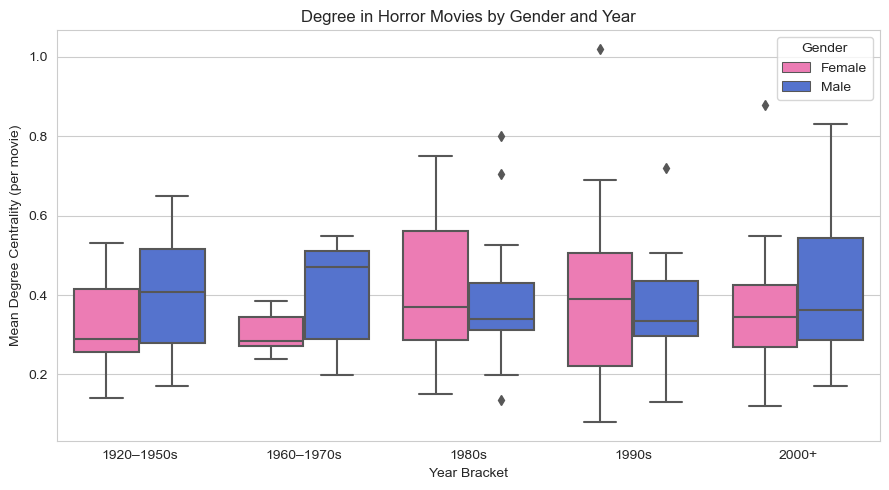

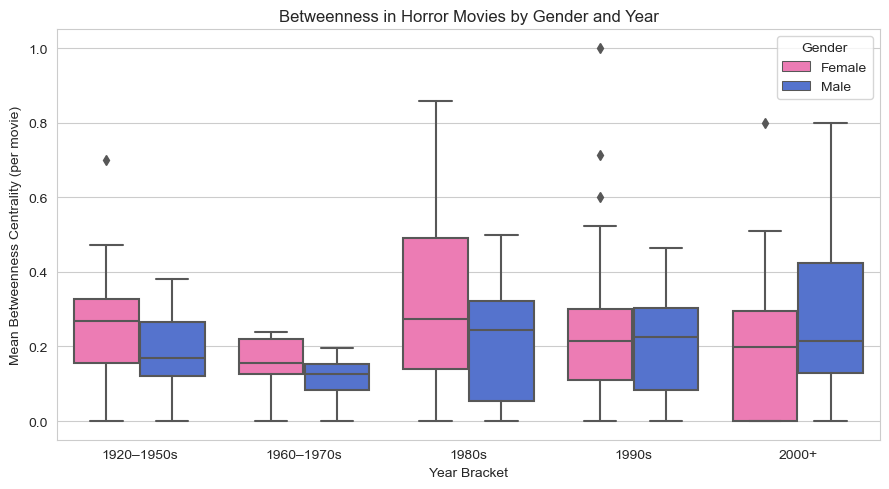

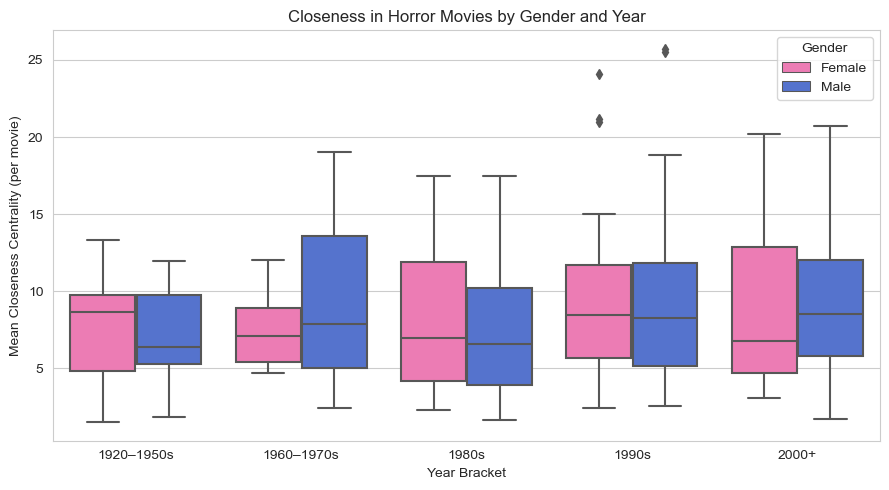

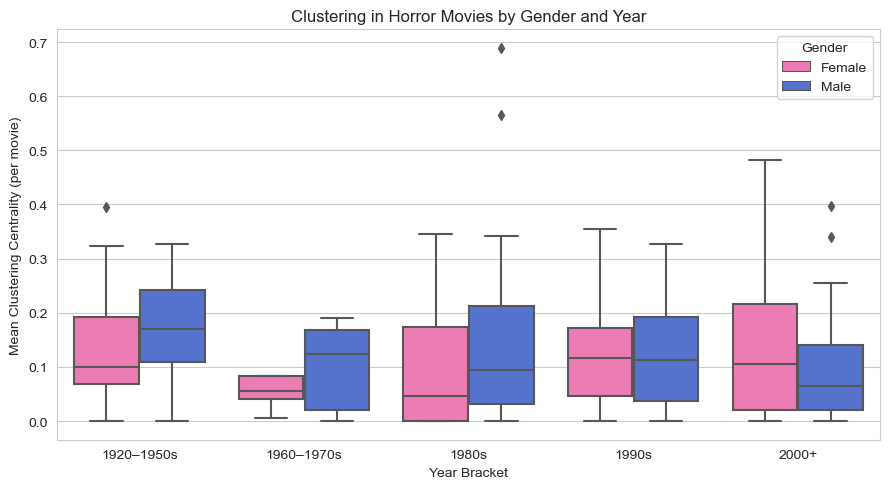

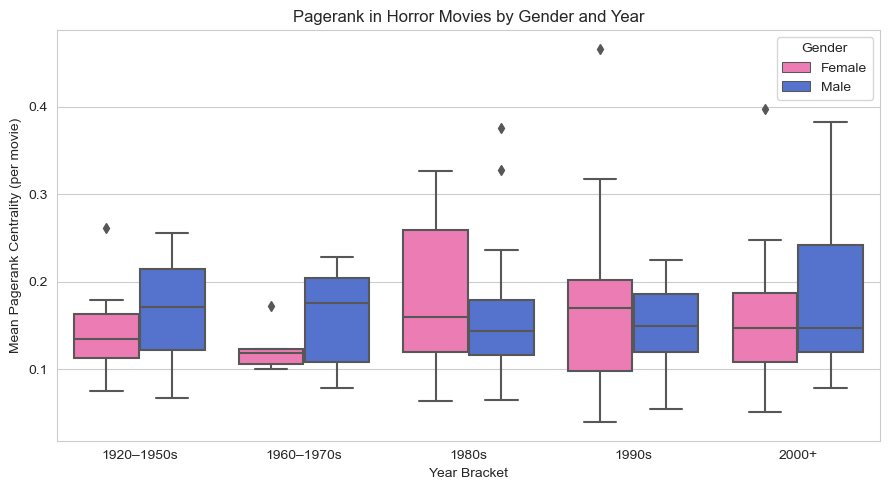

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

for metric in metrics:
    df_long = df_horror.melt(
        id_vars=['year_bracket'],
        value_vars=[f'{metric}_f_mean', f'{metric}_m_mean'],
        var_name='gender', value_name='value'
    )
    df_long['gender'] = df_long['gender'].map({
        f'{metric}_f_mean':'Female',
        f'{metric}_m_mean':'Male'
    })

    plt.figure(figsize=(9,5))
    sns.boxplot(
        x='year_bracket',
        y='value',
        hue='gender',
        data=df_long,
        order=year_order,
        palette=['hotpink','royalblue']
    )
    plt.xlabel('Year Bracket')
    plt.ylabel(f'Mean {metric.title()} Centrality (per movie)')
    plt.title(f'{metric.title()} in Horror Movies by Gender and Year')
    plt.legend(title='Gender')
    plt.tight_layout()
    plt.show()
